In [1]:
%cd ~/work/deeplearning/

/home/asaeed9/work/deeplearning


In [2]:
from theano.sandbox import cuda
cuda.use('gpu1')
%matplotlib inline
from __future__ import print_function, division
#path="../data/2cat/sample"
import utils; reload(utils)
from utils import *
from IPython.display import FileLink
from keras.preprocessing import image, sequence
import os, sys, cv2
from shutil import copyfile, move
from random import shuffle

####
from keras.layers.convolutional import *
from keras.layers.core import Flatten, Dense, Dropout, Lambda
from keras.optimizers import SGD, RMSprop, Adam
import datetime

WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 1: GeForce GTX 980 Ti (CNMeM is disabled, cuDNN 5110)
WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using Theano backend.


In [3]:
data_dir="/home/asaeed9/work/data/2cat"
path="/home/asaeed9/work/data/2cat/sample/"
results_path = "/home/asaeed9/work/data/2cat/sample/results"
test_path = path + '/test/' #We use all the test data
global last_file_timestamp
%cd ../data/2cat/train

/home/asaeed9/work/data/2cat/train


In [4]:
#grey images - minimal image augmentation

    
    #clean previous data
#     os.chdir(path + 'test')
    #adjust_prev_data()
    
    #build validation set
#     g = glob('*.jpg')
#     shuf = np.random.permutation(g)
#     for i in range(validation): os.rename(shuf[i], '../valid/' + shuf[i]) 
    
#     g = glob('*.jpg')
#     shuf = np.random.permutation(g)
#     for i in range(train): os.rename(shuf[i], '../sample/train/' + shuf[i]) 
#     %mv ../sample/train/cat*.jpg ../sample/train/cats/
#     %mv ../sample/train/dog*.jpg ../sample/train/dogs/
    
#     %cd ../valid

#     g = glob('*.jpg')
#     shuf = np.random.permutation(g)
#     for i in range(validation): os.rename(shuf[i], '../sample/valid/' + shuf[i]) 
#     %mv ../sample/valid/cat*.jpg ../sample/valid/cats/
#     %mv ../sample/valid/dog*.jpg ../sample/valid/dogs/
#     %cd $data_dir/train  


def adjust_prev_data_sample():
    %mv $path/train/cats/* $data_dir/train/
    %mv $path/train/dogs/* $data_dir/train/
    %mv $path/valid/cats/* $data_dir/train/
    %mv $path/valid/dogs/* $data_dir/train/

#clean previous data
def adjust_prev_data():
    %mv $data_dir/valid/* $data_dir/train/    
    adjust_prev_data_sample()

#move training images
def move_from_test(new_trainset, path, train, validation):
    print(new_trainset[:10])
    
def move_to_test(images):
    g = glob('*.jpg')
    shuf = np.random.permutation(g)
    for i in range(images): os.rename(shuf[i], '../sample/test/' + shuf[i]) 
    %mv ../sample/test/cat*.jpg ../sample/test/cats/
    %mv ../sample/test/dog*.jpg ../sample/test/dogs/      

    
def handle_null(train, validation):
    g = glob('*.jpg')
    shuf = np.random.permutation(g)
    for i in range(train): copyfile(shuf[i], '../sample/train/' + shuf[i]) 
    %mv ../sample/train/cat*.jpg ../sample/train/cats/
    %mv ../sample/train/dog*.jpg ../sample/train/dogs/
    
    %cd ../valid

    g = glob('*.jpg')
    shuf = np.random.permutation(g)
    for i in range(validation): copyfile(shuf[i], '../sample/valid/' + shuf[i]) 
    %mv ../sample/valid/cat*.jpg ../sample/valid/cats/
    %mv ../sample/valid/dog*.jpg ../sample/valid/dogs/
    %cd $data_dir/train
    
#copy training images
def copy_samples(train, validation):
    #print("Copying new samples for training...")
    #clean previous data
    adjust_prev_data()
    
    #build validation set
    g = glob('*.jpg')
    shuf = np.random.permutation(g)
    for i in range(validation): os.rename(shuf[i], '../valid/' + shuf[i]) 
    
    g = glob('*.jpg')
    shuf = np.random.permutation(g)
    for i in range(train): copyfile(shuf[i], '../sample/train/' + shuf[i]) 
    %mv ../sample/train/cat*.jpg ../sample/train/cats/
    %mv ../sample/train/dog*.jpg ../sample/train/dogs/
    
    %cd ../valid

    g = glob('*.jpg')
    shuf = np.random.permutation(g)
    for i in range(validation): copyfile(shuf[i], '../sample/valid/' + shuf[i]) 
    %mv ../sample/valid/cat*.jpg ../sample/valid/cats/
    %mv ../sample/valid/dog*.jpg ../sample/valid/dogs/
    %cd $data_dir/train

def onehot(x): return np.array(OneHotEncoder().fit_transform(x.reshape(-1,1)).todense())

def pred_batch(imgs, classes):
    preds = model.predict(imgs)
    idxs = np.argmax(preds, axis=1)

    print('Shape: {}'.format(preds.shape))
    print('First 5 classes: {}'.format(classes[:5]))
    print('First 5 probabilities: {}\n'.format(preds[:5]))
    print('Predictions prob/class: ')
    
    for i in range(len(idxs)):
        idx = idxs[i]
        print ('  {:.4f}/{}'.format(preds[i, idx], classes[idx]))


def generate_size_graph(fig_no, training_size, accuracy, loss, start_size, end_size):
    plt.figure(fig_no,figsize=(7,5))
    plt.plot(training_size,accuracy)
    plt.plot(training_size,loss)
    plt.xlabel('Training Size')
    plt.ylabel('Accuracy/Loss')
    plt.title('Training Size vs Accuracy/Loss')
    plt.grid(True)
    plt.legend(['Accuracy','Loss'])
    plt.style.use(['classic'])
    plt.show()
    plt.savefig(path + '/batch_graphs/' +  str(start_size) + '_' + str(end_size) + '.jpg') 
        
def generate_graph(fig_no, epochs, train, val, label, train_title, val_title, train_size):
    plt.figure(fig_no,figsize=(7,5))
    plt.plot(epochs,train)
    plt.plot(epochs,val)
    plt.xlabel('num of Epochs')
    plt.ylabel(label)
    plt.title(train_title + ' vs ' + val_title + '( Samples:' + str(train_size) + ')')
    plt.grid(True)
    plt.legend(['train','val'])
    plt.style.use(['classic'])
    plt.show()
    plt.savefig(results_path + '/batch_graphs/' +  label + '_' + str(train_size) + '.jpg') 
    
def get_train_model(tr_batches, val_batches, epoch):
    model = Sequential([
            BatchNormalization(axis=1, input_shape=(3, 256,256)),
            Convolution2D(32,3,3, activation='relu'),
            BatchNormalization(axis=1),
            MaxPooling2D((3,3)),
            Dropout(0.2),
#             Convolution2D(64,3,3, activation='relu'),
#             BatchNormalization(axis=1),
            #MaxPooling2D((3,3)),
            Convolution2D(64,3,3, activation='relu'),
            BatchNormalization(axis=1),
            MaxPooling2D((3,3)),
            Dropout(0.2),
            Convolution2D(32,3,3, activation='relu'),
            BatchNormalization(axis=1),
            MaxPooling2D((3,3)),
            Dropout(0.2),
            Flatten(),
            Dense(1024, activation='relu'),
            BatchNormalization(),
            Dropout(0.2),
            Dense(2, activation='softmax')
        ])

    model.compile(Adam(lr=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])
    model.fit_generator(tr_batches, tr_batches.nb_sample, nb_epoch=2, validation_data=val_batches, 
                     nb_val_samples=val_batches.nb_sample)
    model.optimizer.lr = 0.001
    model.fit_generator(tr_batches, tr_batches.nb_sample, nb_epoch=epoch - 2, validation_data=val_batches, 
                     nb_val_samples=val_batches.nb_sample)
    return model 

def train_model(model, tr_batches, val_batches, epoch):
    if not model:
        model = Sequential([
                BatchNormalization(axis=1, input_shape=(3, 256,256)),
                Convolution2D(32,3,3, activation='relu'),
                BatchNormalization(axis=1),
                MaxPooling2D((3,3)),
                Dropout(0.2),
    #             Convolution2D(64,3,3, activation='relu'),
    #             BatchNormalization(axis=1),
                #MaxPooling2D((3,3)),
                Convolution2D(64,3,3, activation='relu'),
                BatchNormalization(axis=1),
                MaxPooling2D((3,3)),
                Dropout(0.2),
                Convolution2D(32,3,3, activation='relu'),
                BatchNormalization(axis=1),
                MaxPooling2D((3,3)),
                Dropout(0.2),
                Flatten(),
                Dense(1024, activation='relu'),
                BatchNormalization(),
                Dropout(0.2),
                Dense(2, activation='softmax')
            ])
        model.compile(Adam(lr=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])
       
    model.fit_generator(tr_batches, tr_batches.nb_sample, nb_epoch=2, validation_data=val_batches, 
                     nb_val_samples=val_batches.nb_sample)
    model.optimizer.lr = 0.001
    model.fit_generator(tr_batches, tr_batches.nb_sample, nb_epoch=epoch - 2, validation_data=val_batches, 
                     nb_val_samples=val_batches.nb_sample)
        
    return model 
    
    
def get_test_model():
    model = Sequential([
                BatchNormalization(axis=1, input_shape=(3,256,256)),
                Convolution2D(32,3,3, activation='relu'),
                BatchNormalization(axis=1),
                MaxPooling2D((3,3)),
    #             Convolution2D(64,3,3, activation='relu'),
    #             BatchNormalization(axis=1),
                #MaxPooling2D((3,3)),
                Convolution2D(64,3,3, activation='relu'),
                BatchNormalization(axis=1),
                MaxPooling2D((3,3)),
                Convolution2D(32,3,3, activation='relu'),
                BatchNormalization(axis=1),
                MaxPooling2D((3,3)),
                Flatten(),
                Dense(1024, activation='relu'),
                BatchNormalization(),
                Dense(2, activation='softmax')
            ])

    model.compile(Adam(lr=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])  
    
    return model

def fit(samples_copied, old_model, path, results_path, nepoch, batch_size, train_size, valid_size):
    gen_t = image.ImageDataGenerator(rotation_range=15, height_shift_range=0.05, 
                shear_range=0.1, channel_shift_range=20, width_shift_range=0.1)

    #for train in training_range:
    model = None
    if not samples_copied:
        copy_samples(train_size, valid_size)

    tr_batches = gen_t.flow_from_directory(path + 'train', batch_size=batch_size)
    val_batches = gen_t.flow_from_directory(path + 'valid', class_mode='categorical', shuffle=True, batch_size=batch_size * 2)
    
    if old_model:
        model = train_model(old_model, tr_batches, val_batches, nepoch)
    else:
        model = train_model(None, tr_batches, val_batches, nepoch)
        
    #model.save_weights(results_path+ '/' + 'ft_' + str(train_size) + '.e' + str(nepoch))
    last_file_timestamp = '{:%Y%m%d%H%M%S}'.format(datetime.datetime.now())
    #print('File Time Stamp:{}'.format(last_file_timestamp))
    model.save_weights(results_path+'/ft_{}'.format(last_file_timestamp))
    #model.load_weights(results_path+'/ft_{}'.format(last_file_timestamp))
                          
    return model, last_file_timestamp

def predict(path, model):
    gen_test = image.ImageDataGenerator()
    test_batches = gen_test.flow_from_directory(path+'test', class_mode=None, target_size=(256,256), shuffle=False, batch_size=1)
    test_data = np.concatenate([test_batches.next() for i in range(test_batches.nb_sample)])
    test_labels = onehot(test_batches.classes)
    score = model.evaluate(test_data, test_labels)
    
    probs = model.predict(test_data)
    
    #loss_score.append(score[0])
    #accuracy_score.append(score[1])
    
    print("\nLoss:{}, Accuracy:{}".format(score[0], score[1]))
    #print("\nProbabilities:{}".format(probs))
    return probs, test_batches, score[0], score[1]

def move_samples(retrain_set,dest_path, n, limit):
    cats_copied = 0
    dogs_copied = 0
    retrain_list = list(retrain_set)
    shuffle(retrain_list)
    for fil in range(n):
        fil = retrain_list.pop()
        fil_cpy = fil[fil.find('/')+1:]

        if 'cat' in fil_cpy and cats_copied <= limit:
            os.rename(os.path.join(path + "test/cats/"+ fil_cpy), os.path.join(path + dest_path + "/cats/"+ fil_cpy))
            cats_copied+=1
        elif 'dog' in fil_cpy and dogs_copied <= limit:
            os.rename(os.path.join(path + "test/dogs/"+ fil_cpy), os.path.join(path + dest_path + "/dogs/" + fil_cpy))
            dogs_copied+=1
            
    #print("Limit:", limit)        
    #print("moved cats:", cats_copied)
    #print("moved dogs:", dogs_copied)
    #print("Retrain Length: ", len(retrain_list))
    return retrain_list, cats_copied, dogs_copied


def move_to_train(retrain_set, limit):
    cats = 0
    dogs = 0
    valid_limit = int(math.floor(.2*(limit*2)))
    train_limit = int(math.floor(.8*(limit*2)))
    
    #print(retrain_set[:10])
    print("validation set: ", valid_limit)
    retrain_list, cats_copied, dogs_copied = move_samples(retrain_set, "valid", valid_limit, limit)
    valid_size = cats_copied + dogs_copied
    print("Train set: ", train_limit)
    retrain_list, cats_copied, dogs_copied = move_samples(retrain_list, "train", train_limit, limit)
    train_size = cats_copied + dogs_copied
    
    return train_size, valid_size, train_size + valid_size

def refil_test(nimages):
    os.chdir("/home/asaeed9/work/data/2cat/train")
    g = glob('*.jpg')
    shuf = np.random.permutation(g)
    for i in range(nimages): os.rename(shuf[i], '../sample/test/' + shuf[i])
    #os.chdir("../sample/test/")
    #move("cat*.jpg")
    %mv ../sample/test/cat*.jpg ../sample/test/cats/
    %mv ../sample/test/dog*.jpg ../sample/test/dogs/     

In [6]:
%cd $data_dir/train

nepoch = 30
batch_size = 64
train_size = 100
running_train_size = 100
training_set_size = []
valid_size = int(math.floor(.2 * train_size))
#print('sample size: {}'.format(train_size + valid_size))
tr_model = None
loss = 0.0
loss_array = []
accuracy = 0.0
accuracy_array = []

#copy test data
#move_to_test(3000)

i=0
for i in range(100):
    print("Train Size:{}".format(train_size))
    print("Valid Size:{}".format(valid_size))
    
    if train_size == 0 or valid_size == 0: #handle null case
        handle_null(50,10)
        train_size += 50
        valid_size += 10
        
    tr_model,file_timestamp = fit(i, tr_model, path, results_path, nepoch, batch_size, train_size, valid_size)

    model = None
    model = get_test_model() 
    #model.load_weights(results_path+'/ft_' + str(train_size) + '.e' + str(nepoch))
    #print('{0}/ft_{1}'.format(last_file_timestamp))
    #print('Last File Timestamp- before loading:{}'.format(file_timestamp))
    model.load_weights(results_path+'/ft_{}'.format(file_timestamp))
    
    probs, test_batches,loss, accuracy = predict(path, model)
    training_set_size.append(running_train_size)
    loss_array.append(loss)
    accuracy_array.append(accuracy)

    retrain_idx = np.unique(np.where(np.logical_and(probs >=0.4, probs<=0.7))[0])
    retrain_set = [test_batches.filenames[i] for i in retrain_idx]

    os.chdir(path + 'test')
    ndog = sum('dog' in name for name in retrain_set)
    ncat =  sum('cat' in name for name in retrain_set)
    limit = min(ncat, ndog)

    # print("Total Retrain Images: {}".format(limit*2))

    #print('Images to be retrained:{}'.format(limit*2))
    #print('Dogs:{0}, Cats:{1}, Total:{2}'.format(ndog, ncat, ndog+ncat))

    # # # #remove all train/validation images
    # print("Total Retrain Images: {}".format(limit*2))
    #move existing training data to the store
    adjust_prev_data_sample()
    train_size, valid_size, copied_images = move_to_train(retrain_set, limit)
    running_train_size += train_size
    refil_test(copied_images)

    print('Training Set Size:{}'.format(training_set_size))
    print('Accuracy:{}'.format(accuracy_array))
    print('Loss:{}'.format(loss_array))

print('Training Set Size:{}'.format(training_set_size))
print('Accuracy:{}'.format(accuracy_array))
print('Loss:{}'.format(loss_array))
    


/home/asaeed9/work/data/2cat/train
Train Size:100
Valid Size:20
/home/asaeed9/work/data/2cat/valid
/home/asaeed9/work/data/2cat/train
Found 100 images belonging to 2 classes.
Found 20 images belonging to 2 classes.
Epoch 1/2
100/100 [==============================] - 1s - loss: 1.1930 - acc: 0.5100 - val_loss: 0.9431 - val_acc: 0.5500
Epoch 2/2
100/100 [==============================] - 1s - loss: 1.1037 - acc: 0.4700 - val_loss: 0.9894 - val_acc: 0.5000
Epoch 1/28
100/100 [==============================] - 1s - loss: 1.1350 - acc: 0.5500 - val_loss: 1.2112 - val_acc: 0.5000
Epoch 2/28
100/100 [==============================] - 1s - loss: 0.9468 - acc: 0.5800 - val_loss: 1.3166 - val_acc: 0.5000
Epoch 3/28
100/100 [==============================] - 1s - loss: 0.7897 - acc: 0.5900 - val_loss: 1.6079 - val_acc: 0.5000
Epoch 4/28
100/100 [==============================] - 1s - loss: 0.7489 - acc: 0.6300 - val_loss: 1.7349 - val_acc: 0.5000
Epoch 5/28
100/100 [=============================

252/252 [==============================] - 4s - loss: 1.0154 - acc: 0.5635 - val_loss: 0.7885 - val_acc: 0.4921
Epoch 2/2
252/252 [==============================] - 3s - loss: 1.0089 - acc: 0.6151 - val_loss: 0.8278 - val_acc: 0.4127
Epoch 1/28
252/252 [==============================] - 4s - loss: 0.9589 - acc: 0.6190 - val_loss: 0.7350 - val_acc: 0.5397
Epoch 2/28
252/252 [==============================] - 2s - loss: 0.8889 - acc: 0.6190 - val_loss: 0.7675 - val_acc: 0.5397
Epoch 3/28
252/252 [==============================] - 2s - loss: 0.8464 - acc: 0.6468 - val_loss: 0.7486 - val_acc: 0.5238
Epoch 4/28
252/252 [==============================] - 2s - loss: 0.8582 - acc: 0.6349 - val_loss: 0.7902 - val_acc: 0.5556
Epoch 5/28
252/252 [==============================] - 2s - loss: 0.7936 - acc: 0.6706 - val_loss: 0.7129 - val_acc: 0.6190
Epoch 6/28
252/252 [==============================] - 2s - loss: 0.7991 - acc: 0.6548 - val_loss: 0.7639 - val_acc: 0.5714
Epoch 7/28
252/252 [========

42/42 [==============================] - 1s - loss: 1.0248 - acc: 0.5238 - val_loss: 1.4027 - val_acc: 0.4167
Epoch 2/2
42/42 [==============================] - 0s - loss: 0.8724 - acc: 0.6429 - val_loss: 0.8674 - val_acc: 0.4167
Epoch 1/28
42/42 [==============================] - 1s - loss: 0.6857 - acc: 0.6667 - val_loss: 0.9907 - val_acc: 0.4167
Epoch 2/28
42/42 [==============================] - 0s - loss: 0.6148 - acc: 0.6905 - val_loss: 1.0192 - val_acc: 0.2500
Epoch 3/28
42/42 [==============================] - 0s - loss: 0.6632 - acc: 0.6905 - val_loss: 1.1144 - val_acc: 0.3333
Epoch 4/28
42/42 [==============================] - 0s - loss: 0.4117 - acc: 0.8333 - val_loss: 1.3853 - val_acc: 0.3333
Epoch 5/28
42/42 [==============================] - 0s - loss: 0.5341 - acc: 0.7857 - val_loss: 0.8814 - val_acc: 0.4167
Epoch 6/28
42/42 [==============================] - 0s - loss: 0.4782 - acc: 0.7619 - val_loss: 1.2352 - val_acc: 0.4167
Epoch 7/28
42/42 [==========================

58/58 [==============================] - 1s - loss: 1.0118 - acc: 0.6724 - val_loss: 1.4074 - val_acc: 0.4118
Epoch 2/2
58/58 [==============================] - 0s - loss: 0.8024 - acc: 0.6897 - val_loss: 1.1954 - val_acc: 0.3529
Epoch 1/28
58/58 [==============================] - 1s - loss: 0.8395 - acc: 0.6379 - val_loss: 1.1830 - val_acc: 0.2941
Epoch 2/28
58/58 [==============================] - 0s - loss: 0.6340 - acc: 0.7241 - val_loss: 0.9105 - val_acc: 0.5882
Epoch 3/28
58/58 [==============================] - 0s - loss: 0.6903 - acc: 0.7586 - val_loss: 1.2096 - val_acc: 0.4706
Epoch 4/28
58/58 [==============================] - 0s - loss: 0.6306 - acc: 0.7069 - val_loss: 1.5958 - val_acc: 0.2941
Epoch 5/28
58/58 [==============================] - 0s - loss: 0.7043 - acc: 0.6724 - val_loss: 1.4892 - val_acc: 0.2941
Epoch 6/28
58/58 [==============================] - 0s - loss: 0.8158 - acc: 0.7069 - val_loss: 1.3746 - val_acc: 0.4118
Epoch 7/28
58/58 [==========================

43/43 [==============================] - 0s - loss: 0.9660 - acc: 0.5116 - val_loss: 0.7326 - val_acc: 0.7000
Epoch 2/2
43/43 [==============================] - 0s - loss: 0.9631 - acc: 0.6047 - val_loss: 0.7404 - val_acc: 0.6000
Epoch 1/28
43/43 [==============================] - 0s - loss: 0.7329 - acc: 0.6977 - val_loss: 0.8889 - val_acc: 0.5000
Epoch 2/28
43/43 [==============================] - 0s - loss: 0.9143 - acc: 0.5814 - val_loss: 0.6807 - val_acc: 0.6000
Epoch 3/28
43/43 [==============================] - 0s - loss: 0.9775 - acc: 0.6512 - val_loss: 1.1472 - val_acc: 0.5000
Epoch 4/28
43/43 [==============================] - 0s - loss: 0.6956 - acc: 0.7209 - val_loss: 0.9065 - val_acc: 0.7000
Epoch 5/28
43/43 [==============================] - 0s - loss: 0.5208 - acc: 0.7674 - val_loss: 0.7934 - val_acc: 0.5000
Epoch 6/28
43/43 [==============================] - 0s - loss: 0.8151 - acc: 0.6744 - val_loss: 0.8873 - val_acc: 0.4000
Epoch 7/28
43/43 [==========================

validation set:  19
Train set:  76
Training Set Size:[100, 255, 507, 544, 586, 669, 727, 786, 829, 1097]
Accuracy:[0.51834556370913942, 0.53235490327878665, 0.54069379586390931, 0.55103402269172863, 0.56370913944616563, 0.56170780524323194, 0.57171447635730799, 0.57738492332195102, 0.59472981993956431, 0.607738492358041]
Loss:[0.94627340202573307, 1.069129374521903, 1.6582751717068021, 1.9458960867508639, 1.7672291246949234, 1.8073495392544099, 2.2642813132276847, 2.1801735833585463, 1.4026525458786947, 1.9107522724806427]
Train Size:69
Valid Size:19
Found 69 images belonging to 2 classes.
Found 19 images belonging to 2 classes.
Epoch 1/2
69/69 [==============================] - 1s - loss: 0.9479 - acc: 0.6522 - val_loss: 1.1440 - val_acc: 0.6316
Epoch 2/2
69/69 [==============================] - 0s - loss: 1.0985 - acc: 0.5797 - val_loss: 1.5543 - val_acc: 0.3684
Epoch 1/28
69/69 [==============================] - 1s - loss: 1.1005 - acc: 0.5217 - val_loss: 1.5842 - val_acc: 0.3684
Ep

122/122 [==============================] - 1s - loss: 0.4730 - acc: 0.7377 - val_loss: 1.5004 - val_acc: 0.5333
Epoch 24/28
122/122 [==============================] - 1s - loss: 0.3550 - acc: 0.8689 - val_loss: 1.3455 - val_acc: 0.5333
Epoch 25/28
122/122 [==============================] - 1s - loss: 0.3891 - acc: 0.8361 - val_loss: 1.1964 - val_acc: 0.5667
Epoch 26/28
122/122 [==============================] - 1s - loss: 0.4439 - acc: 0.8033 - val_loss: 1.4679 - val_acc: 0.5000
Epoch 27/28
122/122 [==============================] - 1s - loss: 0.3115 - acc: 0.8525 - val_loss: 1.1862 - val_acc: 0.5333
Epoch 28/28
122/122 [==============================] - 1s - loss: 0.4556 - acc: 0.8115 - val_loss: 1.3605 - val_acc: 0.5000
Found 2998 images belonging to 2 classes.
2976/2998 [============================>.] - ETA: 0s
Loss:1.88586227667, Accuracy:0.624082721824
validation set:  9
Train set:  38
Training Set Size:[100, 255, 507, 544, 586, 669, 727, 786, 829, 1097, 1166, 1288]
Accuracy:[0.5

288/288 [==============================] - 3s - loss: 0.6678 - acc: 0.7049 - val_loss: 1.3657 - val_acc: 0.5278
Epoch 16/28
288/288 [==============================] - 3s - loss: 0.5920 - acc: 0.7431 - val_loss: 1.2659 - val_acc: 0.5139
Epoch 17/28
288/288 [==============================] - 3s - loss: 0.6493 - acc: 0.7396 - val_loss: 1.2747 - val_acc: 0.4722
Epoch 18/28
288/288 [==============================] - 3s - loss: 0.6664 - acc: 0.6944 - val_loss: 1.7384 - val_acc: 0.4722
Epoch 19/28
288/288 [==============================] - 3s - loss: 0.5847 - acc: 0.7431 - val_loss: 1.5426 - val_acc: 0.4861
Epoch 20/28
288/288 [==============================] - 3s - loss: 0.5336 - acc: 0.7535 - val_loss: 1.5078 - val_acc: 0.5278
Epoch 21/28
288/288 [==============================] - 3s - loss: 0.5332 - acc: 0.7396 - val_loss: 1.1727 - val_acc: 0.5417
Epoch 22/28
288/288 [==============================] - 3s - loss: 0.5222 - acc: 0.7535 - val_loss: 1.2149 - val_acc: 0.5556
Epoch 23/28
288/288 

184/184 [==============================] - 2s - loss: 0.6819 - acc: 0.6685 - val_loss: 1.1472 - val_acc: 0.5870
Epoch 6/28
184/184 [==============================] - 2s - loss: 0.7240 - acc: 0.6250 - val_loss: 1.3127 - val_acc: 0.5000
Epoch 7/28
184/184 [==============================] - 1s - loss: 0.7238 - acc: 0.6413 - val_loss: 1.3916 - val_acc: 0.5217
Epoch 8/28
184/184 [==============================] - 2s - loss: 0.6335 - acc: 0.6848 - val_loss: 1.2675 - val_acc: 0.5652
Epoch 9/28
184/184 [==============================] - 1s - loss: 0.6580 - acc: 0.6359 - val_loss: 1.1619 - val_acc: 0.6522
Epoch 10/28
184/184 [==============================] - 1s - loss: 0.6571 - acc: 0.6359 - val_loss: 1.0576 - val_acc: 0.6087
Epoch 11/28
184/184 [==============================] - 2s - loss: 0.6420 - acc: 0.6793 - val_loss: 1.7111 - val_acc: 0.4565
Epoch 12/28
184/184 [==============================] - 2s - loss: 0.6687 - acc: 0.6793 - val_loss: 1.3630 - val_acc: 0.5217
Epoch 13/28
184/184 [===

260/260 [==============================] - 4s - loss: 1.0635 - acc: 0.5538 - val_loss: 1.0398 - val_acc: 0.6615
Epoch 2/2
260/260 [==============================] - 2s - loss: 1.0172 - acc: 0.5423 - val_loss: 1.1013 - val_acc: 0.4923
Epoch 1/28
260/260 [==============================] - 4s - loss: 0.8639 - acc: 0.5846 - val_loss: 0.9340 - val_acc: 0.6154
Epoch 2/28
260/260 [==============================] - 2s - loss: 0.8483 - acc: 0.5885 - val_loss: 1.0070 - val_acc: 0.5385
Epoch 3/28
260/260 [==============================] - 2s - loss: 0.9489 - acc: 0.5846 - val_loss: 1.4028 - val_acc: 0.5692
Epoch 4/28
260/260 [==============================] - 2s - loss: 0.8142 - acc: 0.5962 - val_loss: 1.4356 - val_acc: 0.5077
Epoch 5/28
260/260 [==============================] - 2s - loss: 0.8191 - acc: 0.5885 - val_loss: 0.9483 - val_acc: 0.5846
Epoch 6/28
260/260 [==============================] - 2s - loss: 0.7785 - acc: 0.6269 - val_loss: 1.0134 - val_acc: 0.6154
Epoch 7/28
260/260 [========

171/171 [==============================] - 1s - loss: 0.4926 - acc: 0.7661 - val_loss: 1.0341 - val_acc: 0.6667
Epoch 27/28
171/171 [==============================] - 1s - loss: 0.4737 - acc: 0.7778 - val_loss: 0.7778 - val_acc: 0.5714
Epoch 28/28
171/171 [==============================] - 1s - loss: 0.5477 - acc: 0.7544 - val_loss: 1.1656 - val_acc: 0.5476
Found 2998 images belonging to 2 classes.
2976/2998 [============================>.] - ETA: 0s
Loss:1.49158683972, Accuracy:0.712474983362
validation set:  38
Train set:  152
Training Set Size:[100, 255, 507, 544, 586, 669, 727, 786, 829, 1097, 1166, 1288, 1322, 1610, 1795, 1979, 2124, 2384, 2555]
Accuracy:[0.51834556370913942, 0.53235490327878665, 0.54069379586390931, 0.55103402269172863, 0.56370913944616563, 0.56170780524323194, 0.57171447635730799, 0.57738492332195102, 0.59472981993956431, 0.607738492358041, 0.61674449629112427, 0.62408272182448377, 0.65310206809506721, 0.6711140761103449, 0.67645096735130394, 0.69246164113382569

196/196 [==============================] - 2s - loss: 0.7753 - acc: 0.6071 - val_loss: 1.3743 - val_acc: 0.5714
Epoch 13/28
196/196 [==============================] - 2s - loss: 0.6988 - acc: 0.6378 - val_loss: 1.3858 - val_acc: 0.4898
Epoch 14/28
196/196 [==============================] - 2s - loss: 0.6439 - acc: 0.6837 - val_loss: 1.0766 - val_acc: 0.5714
Epoch 15/28
196/196 [==============================] - 3s - loss: 0.6514 - acc: 0.6378 - val_loss: 0.9848 - val_acc: 0.4898
Epoch 16/28
196/196 [==============================] - 2s - loss: 0.6286 - acc: 0.6990 - val_loss: 1.5371 - val_acc: 0.5306
Epoch 17/28
196/196 [==============================] - 2s - loss: 0.5799 - acc: 0.7449 - val_loss: 1.2527 - val_acc: 0.5102
Epoch 18/28
196/196 [==============================] - 2s - loss: 0.6033 - acc: 0.7398 - val_loss: 1.1542 - val_acc: 0.5714
Epoch 19/28
196/196 [==============================] - 2s - loss: 0.6235 - acc: 0.6990 - val_loss: 1.2671 - val_acc: 0.6122
Epoch 20/28
196/196 

63/63 [==============================] - 1s - loss: 0.8113 - acc: 0.5397 - val_loss: 1.6112 - val_acc: 0.3750
Epoch 2/2
63/63 [==============================] - 0s - loss: 0.7067 - acc: 0.6349 - val_loss: 1.3433 - val_acc: 0.6250
Epoch 1/28
63/63 [==============================] - 1s - loss: 0.8767 - acc: 0.5873 - val_loss: 1.5902 - val_acc: 0.2500
Epoch 2/28
63/63 [==============================] - 0s - loss: 0.7462 - acc: 0.6349 - val_loss: 1.6666 - val_acc: 0.1250
Epoch 3/28
63/63 [==============================] - 0s - loss: 0.6834 - acc: 0.6984 - val_loss: 2.0892 - val_acc: 0.0625
Epoch 4/28
63/63 [==============================] - 0s - loss: 0.8316 - acc: 0.6032 - val_loss: 2.5140 - val_acc: 0.4375
Epoch 5/28
63/63 [==============================] - 0s - loss: 0.7838 - acc: 0.5873 - val_loss: 1.8275 - val_acc: 0.1875
Epoch 6/28
63/63 [==============================] - 0s - loss: 0.8782 - acc: 0.5873 - val_loss: 1.2679 - val_acc: 0.1875
Epoch 7/28
63/63 [==========================

73/73 [==============================] - 0s - loss: 0.3902 - acc: 0.8493 - val_loss: 0.5202 - val_acc: 0.6842
Epoch 26/28
73/73 [==============================] - 0s - loss: 0.2738 - acc: 0.8767 - val_loss: 0.5421 - val_acc: 0.7368
Epoch 27/28
73/73 [==============================] - 0s - loss: 0.3530 - acc: 0.8493 - val_loss: 0.6725 - val_acc: 0.5263
Epoch 28/28
73/73 [==============================] - 0s - loss: 0.2751 - acc: 0.8767 - val_loss: 1.0177 - val_acc: 0.6842
Found 2998 images belonging to 2 classes.
2998/2998 [==============================] - 3s     

Loss:1.3743048966, Accuracy:0.724816544423
validation set:  38
Train set:  155
Training Set Size:[100, 255, 507, 544, 586, 669, 727, 786, 829, 1097, 1166, 1288, 1322, 1610, 1795, 1979, 2124, 2384, 2555, 2707, 2903, 3015, 3078, 3151]
Accuracy:[0.51834556370913942, 0.53235490327878665, 0.54069379586390931, 0.55103402269172863, 0.56370913944616563, 0.56170780524323194, 0.57171447635730799, 0.57738492332195102, 0.594729819939564

118/118 [==============================] - 1s - loss: 0.6315 - acc: 0.6186 - val_loss: 1.1699 - val_acc: 0.5517
Epoch 8/28
118/118 [==============================] - 2s - loss: 0.4939 - acc: 0.7881 - val_loss: 1.1088 - val_acc: 0.6207
Epoch 9/28
118/118 [==============================] - 1s - loss: 0.5025 - acc: 0.7542 - val_loss: 1.2762 - val_acc: 0.6897
Epoch 10/28
118/118 [==============================] - 1s - loss: 0.4979 - acc: 0.7966 - val_loss: 1.0906 - val_acc: 0.6552
Epoch 11/28
118/118 [==============================] - 1s - loss: 0.5668 - acc: 0.7458 - val_loss: 1.1527 - val_acc: 0.7241
Epoch 12/28
118/118 [==============================] - 1s - loss: 0.5376 - acc: 0.7119 - val_loss: 1.2866 - val_acc: 0.7241
Epoch 13/28
118/118 [==============================] - 1s - loss: 0.5289 - acc: 0.7373 - val_loss: 0.9155 - val_acc: 0.6897
Epoch 14/28
118/118 [==============================] - 1s - loss: 0.5147 - acc: 0.7797 - val_loss: 1.0553 - val_acc: 0.6207
Epoch 15/28
118/118 [=

64/64 [==============================] - 1s - loss: 0.9216 - acc: 0.5312 - val_loss: 1.0664 - val_acc: 0.3125
Epoch 2/2
64/64 [==============================] - 0s - loss: 0.9929 - acc: 0.5781 - val_loss: 0.8284 - val_acc: 0.5625
Epoch 1/28
64/64 [==============================] - 1s - loss: 0.8995 - acc: 0.5469 - val_loss: 1.2522 - val_acc: 0.3750
Epoch 2/28
64/64 [==============================] - 0s - loss: 0.8979 - acc: 0.5625 - val_loss: 1.3235 - val_acc: 0.4375
Epoch 3/28
64/64 [==============================] - 0s - loss: 0.8146 - acc: 0.5938 - val_loss: 0.5800 - val_acc: 0.6875
Epoch 4/28
64/64 [==============================] - 0s - loss: 0.8821 - acc: 0.5625 - val_loss: 1.0217 - val_acc: 0.6875
Epoch 5/28
64/64 [==============================] - 0s - loss: 0.8143 - acc: 0.6250 - val_loss: 1.0743 - val_acc: 0.5625
Epoch 6/28
64/64 [==============================] - 0s - loss: 0.6449 - acc: 0.6875 - val_loss: 0.9632 - val_acc: 0.4375
Epoch 7/28
64/64 [==========================

70/70 [==============================] - 0s - loss: 0.3463 - acc: 0.8429 - val_loss: 0.7514 - val_acc: 0.7059
Epoch 24/28
70/70 [==============================] - 0s - loss: 0.4056 - acc: 0.8571 - val_loss: 0.7374 - val_acc: 0.5882
Epoch 25/28
70/70 [==============================] - 0s - loss: 0.3236 - acc: 0.8857 - val_loss: 0.6720 - val_acc: 0.5882
Epoch 26/28
70/70 [==============================] - 0s - loss: 0.3192 - acc: 0.9286 - val_loss: 0.6767 - val_acc: 0.7647
Epoch 27/28
70/70 [==============================] - 0s - loss: 0.3260 - acc: 0.8429 - val_loss: 0.7877 - val_acc: 0.6471
Epoch 28/28
70/70 [==============================] - 0s - loss: 0.2558 - acc: 0.9286 - val_loss: 1.6077 - val_acc: 0.4118
Found 2998 images belonging to 2 classes.
2976/2998 [============================>.] - ETA: 0s
Loss:1.48089979037, Accuracy:0.730486991288
validation set:  37
Train set:  148
Training Set Size:[100, 255, 507, 544, 586, 669, 727, 786, 829, 1097, 1166, 1288, 1322, 1610, 1795, 1979,

222/222 [==============================] - 2s - loss: 0.7444 - acc: 0.6306 - val_loss: 1.1625 - val_acc: 0.4909
Epoch 3/28
222/222 [==============================] - 2s - loss: 0.7340 - acc: 0.6126 - val_loss: 1.0161 - val_acc: 0.6909
Epoch 4/28
222/222 [==============================] - 2s - loss: 0.7104 - acc: 0.6441 - val_loss: 1.1226 - val_acc: 0.6000
Epoch 5/28
222/222 [==============================] - 2s - loss: 0.6942 - acc: 0.6171 - val_loss: 0.7976 - val_acc: 0.6182
Epoch 6/28
222/222 [==============================] - 2s - loss: 0.6491 - acc: 0.6486 - val_loss: 1.0128 - val_acc: 0.5455
Epoch 7/28
222/222 [==============================] - 2s - loss: 0.6862 - acc: 0.6351 - val_loss: 0.8330 - val_acc: 0.6182
Epoch 8/28
222/222 [==============================] - 2s - loss: 0.6887 - acc: 0.6486 - val_loss: 0.9258 - val_acc: 0.5455
Epoch 9/28
222/222 [==============================] - 2s - loss: 0.6922 - acc: 0.6532 - val_loss: 0.9690 - val_acc: 0.5455
Epoch 10/28
222/222 [======

219/219 [==============================] - 3s - loss: 0.4397 - acc: 0.8128 - val_loss: 1.1487 - val_acc: 0.5370
Epoch 25/28
219/219 [==============================] - 2s - loss: 0.4471 - acc: 0.7854 - val_loss: 1.0535 - val_acc: 0.5741
Epoch 26/28
219/219 [==============================] - 2s - loss: 0.4332 - acc: 0.7900 - val_loss: 1.2578 - val_acc: 0.5185
Epoch 27/28
219/219 [==============================] - 2s - loss: 0.4085 - acc: 0.8265 - val_loss: 1.2820 - val_acc: 0.5185
Epoch 28/28
219/219 [==============================] - 2s - loss: 0.4194 - acc: 0.8128 - val_loss: 1.0688 - val_acc: 0.5926
Found 2998 images belonging to 2 classes.
2976/2998 [============================>.] - ETA: 0s
Loss:1.04158865282, Accuracy:0.769513008772
validation set:  38
Train set:  152
Training Set Size:[100, 255, 507, 544, 586, 669, 727, 786, 829, 1097, 1166, 1288, 1322, 1610, 1795, 1979, 2124, 2384, 2555, 2707, 2903, 3015, 3078, 3151, 3306, 3424, 3480, 3544, 3614, 3762, 3984, 4203]
Accuracy:[0.518

147/147 [==============================] - 1s - loss: 0.7808 - acc: 0.6054 - val_loss: 0.9676 - val_acc: 0.6389
Epoch 1/28
147/147 [==============================] - 3s - loss: 0.7686 - acc: 0.5850 - val_loss: 1.3082 - val_acc: 0.4167
Epoch 2/28
147/147 [==============================] - 1s - loss: 0.6728 - acc: 0.6259 - val_loss: 1.2065 - val_acc: 0.5833
Epoch 3/28
147/147 [==============================] - 1s - loss: 0.7274 - acc: 0.6190 - val_loss: 1.0182 - val_acc: 0.4722
Epoch 4/28
147/147 [==============================] - 1s - loss: 0.7160 - acc: 0.6327 - val_loss: 0.9521 - val_acc: 0.6111
Epoch 5/28
147/147 [==============================] - 1s - loss: 0.6713 - acc: 0.6667 - val_loss: 1.1430 - val_acc: 0.4444
Epoch 6/28
147/147 [==============================] - 1s - loss: 0.6712 - acc: 0.6463 - val_loss: 1.1627 - val_acc: 0.4444
Epoch 7/28
147/147 [==============================] - 1s - loss: 0.7365 - acc: 0.6327 - val_loss: 1.0419 - val_acc: 0.5833
Epoch 8/28
147/147 [=======

136/136 [==============================] - 1s - loss: 0.4801 - acc: 0.7794 - val_loss: 0.9431 - val_acc: 0.5294
Epoch 21/28
136/136 [==============================] - 1s - loss: 0.4091 - acc: 0.7794 - val_loss: 1.1270 - val_acc: 0.5294
Epoch 22/28
136/136 [==============================] - 1s - loss: 0.3879 - acc: 0.8162 - val_loss: 0.9378 - val_acc: 0.5294
Epoch 23/28
136/136 [==============================] - 1s - loss: 0.4568 - acc: 0.7721 - val_loss: 1.1390 - val_acc: 0.5882
Epoch 24/28
136/136 [==============================] - 1s - loss: 0.4553 - acc: 0.8088 - val_loss: 1.0585 - val_acc: 0.5882
Epoch 25/28
136/136 [==============================] - 1s - loss: 0.3657 - acc: 0.8676 - val_loss: 1.0066 - val_acc: 0.5588
Epoch 26/28
136/136 [==============================] - 1s - loss: 0.4185 - acc: 0.7941 - val_loss: 1.0991 - val_acc: 0.5294
Epoch 27/28
136/136 [==============================] - 1s - loss: 0.4077 - acc: 0.8162 - val_loss: 0.7441 - val_acc: 0.5882
Epoch 28/28
136/136 

72/72 [==============================] - 1s - loss: 0.7354 - acc: 0.6389 - val_loss: 1.0533 - val_acc: 0.5000
Epoch 2/2
72/72 [==============================] - 0s - loss: 0.7474 - acc: 0.6667 - val_loss: 1.3219 - val_acc: 0.5000
Epoch 1/28
72/72 [==============================] - 1s - loss: 0.7406 - acc: 0.6111 - val_loss: 1.1541 - val_acc: 0.3889
Epoch 2/28
72/72 [==============================] - 0s - loss: 0.6464 - acc: 0.7222 - val_loss: 1.2401 - val_acc: 0.5000
Epoch 3/28
72/72 [==============================] - 0s - loss: 0.6322 - acc: 0.6944 - val_loss: 1.1413 - val_acc: 0.3333
Epoch 4/28
72/72 [==============================] - 0s - loss: 0.5606 - acc: 0.7083 - val_loss: 0.9763 - val_acc: 0.5556
Epoch 5/28
72/72 [==============================] - 0s - loss: 0.6714 - acc: 0.6389 - val_loss: 0.9734 - val_acc: 0.5000
Epoch 6/28
72/72 [==============================] - 0s - loss: 0.4892 - acc: 0.7778 - val_loss: 1.7858 - val_acc: 0.3889
Epoch 7/28
72/72 [==========================

88/88 [==============================] - 1s - loss: 0.4878 - acc: 0.7386 - val_loss: 0.7929 - val_acc: 0.7273
Epoch 20/28
88/88 [==============================] - 0s - loss: 0.3690 - acc: 0.8409 - val_loss: 0.7803 - val_acc: 0.7273
Epoch 21/28
88/88 [==============================] - 1s - loss: 0.3636 - acc: 0.8409 - val_loss: 0.6642 - val_acc: 0.8636
Epoch 22/28
88/88 [==============================] - 0s - loss: 0.3909 - acc: 0.8409 - val_loss: 0.8189 - val_acc: 0.7273
Epoch 23/28
88/88 [==============================] - 0s - loss: 0.3766 - acc: 0.8864 - val_loss: 1.0093 - val_acc: 0.5455
Epoch 24/28
88/88 [==============================] - 1s - loss: 0.3293 - acc: 0.9091 - val_loss: 1.0458 - val_acc: 0.6818
Epoch 25/28
88/88 [==============================] - 0s - loss: 0.3038 - acc: 0.8977 - val_loss: 1.2351 - val_acc: 0.5909
Epoch 26/28
88/88 [==============================] - 0s - loss: 0.3700 - acc: 0.8068 - val_loss: 1.0721 - val_acc: 0.7273
Epoch 27/28
88/88 [=================

28/28 [==============================] - 0s - loss: 0.9554 - acc: 0.5357 - val_loss: 0.6024 - val_acc: 0.6250
Epoch 2/2
28/28 [==============================] - 0s - loss: 0.6815 - acc: 0.6786 - val_loss: 0.8533 - val_acc: 0.5000
Epoch 1/28
28/28 [==============================] - 0s - loss: 0.6146 - acc: 0.6786 - val_loss: 1.4087 - val_acc: 0.5000
Epoch 2/28
28/28 [==============================] - 0s - loss: 0.6809 - acc: 0.6071 - val_loss: 0.6438 - val_acc: 0.6250
Epoch 3/28
28/28 [==============================] - 0s - loss: 0.6931 - acc: 0.6786 - val_loss: 0.8947 - val_acc: 0.3750
Epoch 4/28
28/28 [==============================] - 0s - loss: 0.6987 - acc: 0.6071 - val_loss: 0.7466 - val_acc: 0.5000
Epoch 5/28
28/28 [==============================] - 0s - loss: 0.7621 - acc: 0.6429 - val_loss: 0.4767 - val_acc: 0.7500
Epoch 6/28
28/28 [==============================] - 0s - loss: 0.7095 - acc: 0.7143 - val_loss: 1.1659 - val_acc: 0.3750
Epoch 7/28
28/28 [==========================

12/12 [==============================] - 0s - loss: 0.2162 - acc: 1.0000 - val_loss: 4.5113 - val_acc: 0.3333
Epoch 19/28
12/12 [==============================] - 0s - loss: 0.1714 - acc: 1.0000 - val_loss: 2.8214 - val_acc: 0.3333
Epoch 20/28
12/12 [==============================] - 0s - loss: 0.2697 - acc: 0.9167 - val_loss: 3.8411 - val_acc: 0.0000e+00
Epoch 21/28
12/12 [==============================] - 0s - loss: 0.1095 - acc: 1.0000 - val_loss: 5.4502 - val_acc: 0.0000e+00
Epoch 22/28
12/12 [==============================] - 0s - loss: 0.2285 - acc: 0.8333 - val_loss: 3.3987 - val_acc: 0.3333
Epoch 23/28
12/12 [==============================] - 0s - loss: 0.1789 - acc: 1.0000 - val_loss: 3.8275 - val_acc: 0.3333
Epoch 24/28
12/12 [==============================] - 0s - loss: 0.1509 - acc: 0.9167 - val_loss: 2.1424 - val_acc: 0.0000e+00
Epoch 25/28
12/12 [==============================] - 0s - loss: 0.0773 - acc: 1.0000 - val_loss: 0.5372 - val_acc: 0.6667
Epoch 26/28
12/12 [=====

34/34 [==============================] - 0s - loss: 0.9547 - acc: 0.5000 - val_loss: 1.3303 - val_acc: 0.3333
Epoch 2/2
34/34 [==============================] - 0s - loss: 0.8147 - acc: 0.5588 - val_loss: 2.7171 - val_acc: 0.2222
Epoch 1/28
34/34 [==============================] - 0s - loss: 0.8983 - acc: 0.5588 - val_loss: 2.4282 - val_acc: 0.2222
Epoch 2/28
34/34 [==============================] - 0s - loss: 0.6233 - acc: 0.7647 - val_loss: 1.1208 - val_acc: 0.4444
Epoch 3/28
34/34 [==============================] - 0s - loss: 0.8474 - acc: 0.6471 - val_loss: 2.4653 - val_acc: 0.4444
Epoch 4/28
34/34 [==============================] - 0s - loss: 0.7206 - acc: 0.7059 - val_loss: 3.0507 - val_acc: 0.2222
Epoch 5/28
34/34 [==============================] - 0s - loss: 0.8355 - acc: 0.5882 - val_loss: 1.2687 - val_acc: 0.3333
Epoch 6/28
34/34 [==============================] - 0s - loss: 0.6943 - acc: 0.6765 - val_loss: 2.0005 - val_acc: 0.3333
Epoch 7/28
34/34 [==========================

25/25 [==============================] - 0s - loss: 0.3446 - acc: 0.8400 - val_loss: 0.9726 - val_acc: 0.7143
Epoch 18/28
25/25 [==============================] - 0s - loss: 0.2880 - acc: 0.9200 - val_loss: 0.2734 - val_acc: 0.8571
Epoch 19/28
25/25 [==============================] - 0s - loss: 0.3824 - acc: 0.8400 - val_loss: 0.5288 - val_acc: 0.7143
Epoch 20/28
25/25 [==============================] - 0s - loss: 0.4456 - acc: 0.8400 - val_loss: 0.4173 - val_acc: 0.8571
Epoch 21/28
25/25 [==============================] - 0s - loss: 0.3220 - acc: 0.8400 - val_loss: 0.3313 - val_acc: 0.8571
Epoch 22/28
25/25 [==============================] - 0s - loss: 0.2961 - acc: 0.8000 - val_loss: 0.6573 - val_acc: 0.5714
Epoch 23/28
25/25 [==============================] - 0s - loss: 0.2547 - acc: 0.8800 - val_loss: 0.3785 - val_acc: 0.8571
Epoch 24/28
25/25 [==============================] - 0s - loss: 0.3265 - acc: 0.8400 - val_loss: 0.4768 - val_acc: 0.8571
Epoch 25/28
25/25 [=================

42/42 [==============================] - 0s - loss: 0.9370 - acc: 0.5476 - val_loss: 0.8410 - val_acc: 0.6364
Epoch 2/2
42/42 [==============================] - 0s - loss: 0.6397 - acc: 0.7143 - val_loss: 1.3621 - val_acc: 0.4545
Epoch 1/28
42/42 [==============================] - 1s - loss: 0.7565 - acc: 0.6905 - val_loss: 1.5183 - val_acc: 0.4545
Epoch 2/28
42/42 [==============================] - 0s - loss: 0.6648 - acc: 0.6667 - val_loss: 0.6172 - val_acc: 0.5455
Epoch 3/28
42/42 [==============================] - 0s - loss: 0.7536 - acc: 0.6429 - val_loss: 1.4755 - val_acc: 0.6364
Epoch 4/28
42/42 [==============================] - 0s - loss: 0.6379 - acc: 0.6667 - val_loss: 0.8760 - val_acc: 0.5455
Epoch 5/28
42/42 [==============================] - 0s - loss: 0.5147 - acc: 0.7619 - val_loss: 1.4259 - val_acc: 0.4545
Epoch 6/28
42/42 [==============================] - 0s - loss: 0.5427 - acc: 0.7619 - val_loss: 0.9148 - val_acc: 0.6364
Epoch 7/28
42/42 [==========================

33/33 [==============================] - 0s - loss: 0.4193 - acc: 0.8182 - val_loss: 1.8218 - val_acc: 0.6250
Epoch 17/28
33/33 [==============================] - 0s - loss: 0.3580 - acc: 0.8485 - val_loss: 2.7363 - val_acc: 0.5000
Epoch 18/28
33/33 [==============================] - 0s - loss: 0.4248 - acc: 0.8182 - val_loss: 1.5476 - val_acc: 0.7500
Epoch 19/28
33/33 [==============================] - 0s - loss: 0.4919 - acc: 0.7576 - val_loss: 0.8790 - val_acc: 0.7500
Epoch 20/28
33/33 [==============================] - 0s - loss: 0.4020 - acc: 0.8182 - val_loss: 1.5475 - val_acc: 0.6250
Epoch 21/28
33/33 [==============================] - 0s - loss: 0.4564 - acc: 0.8182 - val_loss: 1.8935 - val_acc: 0.6250
Epoch 22/28
33/33 [==============================] - 0s - loss: 0.2373 - acc: 0.8788 - val_loss: 2.8644 - val_acc: 0.3750
Epoch 23/28
33/33 [==============================] - 0s - loss: 0.3592 - acc: 0.8788 - val_loss: 1.5288 - val_acc: 0.5000
Epoch 24/28
33/33 [=================

26/26 [==============================] - 0s - loss: 1.0020 - acc: 0.5385 - val_loss: 1.8471 - val_acc: 0.3333
Epoch 2/2
26/26 [==============================] - 0s - loss: 0.8864 - acc: 0.5385 - val_loss: 3.9534 - val_acc: 0.1667
Epoch 1/28
26/26 [==============================] - 0s - loss: 1.3561 - acc: 0.4231 - val_loss: 2.0110 - val_acc: 0.3333
Epoch 2/28
26/26 [==============================] - 0s - loss: 1.1147 - acc: 0.3846 - val_loss: 0.6836 - val_acc: 0.5000
Epoch 3/28
26/26 [==============================] - 0s - loss: 1.0317 - acc: 0.5385 - val_loss: 1.8137 - val_acc: 0.3333
Epoch 4/28
26/26 [==============================] - 0s - loss: 0.7614 - acc: 0.6923 - val_loss: 3.4847 - val_acc: 0.3333
Epoch 5/28
26/26 [==============================] - 0s - loss: 0.7114 - acc: 0.6538 - val_loss: 3.4467 - val_acc: 0.3333
Epoch 6/28
26/26 [==============================] - 0s - loss: 0.6553 - acc: 0.6538 - val_loss: 2.8509 - val_acc: 0.5000
Epoch 7/28
26/26 [==========================

41/41 [==============================] - 0s - loss: 0.2324 - acc: 0.9268 - val_loss: 1.1191 - val_acc: 0.5000
Epoch 16/28
41/41 [==============================] - 0s - loss: 0.2917 - acc: 0.9024 - val_loss: 1.4554 - val_acc: 0.8000
Epoch 17/28
41/41 [==============================] - 0s - loss: 0.2950 - acc: 0.8537 - val_loss: 1.4884 - val_acc: 0.6000
Epoch 18/28
41/41 [==============================] - 0s - loss: 0.3876 - acc: 0.7317 - val_loss: 0.3755 - val_acc: 0.7000
Epoch 19/28
41/41 [==============================] - 0s - loss: 0.3066 - acc: 0.8049 - val_loss: 0.5977 - val_acc: 0.8000
Epoch 20/28
41/41 [==============================] - 0s - loss: 0.2039 - acc: 0.9268 - val_loss: 1.0435 - val_acc: 0.6000
Epoch 21/28
41/41 [==============================] - 0s - loss: 0.3584 - acc: 0.8537 - val_loss: 0.7866 - val_acc: 0.7000
Epoch 22/28
41/41 [==============================] - 0s - loss: 0.3171 - acc: 0.8537 - val_loss: 0.9832 - val_acc: 0.7000
Epoch 23/28
41/41 [=================

65/65 [==============================] - 1s - loss: 1.0790 - acc: 0.4923 - val_loss: 0.7821 - val_acc: 0.6875
Epoch 2/2
65/65 [==============================] - 0s - loss: 1.0181 - acc: 0.5231 - val_loss: 0.7410 - val_acc: 0.6875
Epoch 1/28
65/65 [==============================] - 1s - loss: 1.2622 - acc: 0.4615 - val_loss: 0.5723 - val_acc: 0.7500
Epoch 2/28
65/65 [==============================] - 0s - loss: 0.9356 - acc: 0.5846 - val_loss: 0.7269 - val_acc: 0.7500
Epoch 3/28
65/65 [==============================] - 0s - loss: 0.9331 - acc: 0.4769 - val_loss: 1.1171 - val_acc: 0.6250
Epoch 4/28
65/65 [==============================] - 0s - loss: 0.8745 - acc: 0.5231 - val_loss: 1.3089 - val_acc: 0.5625
Epoch 5/28
65/65 [==============================] - 0s - loss: 0.8274 - acc: 0.4923 - val_loss: 1.2321 - val_acc: 0.6875
Epoch 6/28
65/65 [==============================] - 0s - loss: 0.8405 - acc: 0.6000 - val_loss: 1.1369 - val_acc: 0.6875
Epoch 7/28
65/65 [==========================

36/36 [==============================] - 0s - loss: 0.3803 - acc: 0.8056 - val_loss: 1.3967 - val_acc: 0.4444
Epoch 15/28
36/36 [==============================] - 0s - loss: 0.5466 - acc: 0.7500 - val_loss: 0.8703 - val_acc: 0.7778
Epoch 16/28
36/36 [==============================] - 0s - loss: 0.4586 - acc: 0.8333 - val_loss: 3.0665 - val_acc: 0.3333
Epoch 17/28
36/36 [==============================] - 0s - loss: 0.3850 - acc: 0.7778 - val_loss: 2.0050 - val_acc: 0.4444
Epoch 18/28
36/36 [==============================] - 0s - loss: 0.4223 - acc: 0.7500 - val_loss: 1.6527 - val_acc: 0.3333
Epoch 19/28
36/36 [==============================] - 0s - loss: 0.3841 - acc: 0.7778 - val_loss: 1.9318 - val_acc: 0.4444
Epoch 20/28
36/36 [==============================] - 0s - loss: 0.4804 - acc: 0.8333 - val_loss: 1.5809 - val_acc: 0.1111
Epoch 21/28
36/36 [==============================] - 0s - loss: 0.4057 - acc: 0.8889 - val_loss: 2.3714 - val_acc: 0.2222
Epoch 22/28
36/36 [=================

107/107 [==============================] - 1s - loss: 0.3623 - acc: 0.8505 - val_loss: 1.4424 - val_acc: 0.6154
Found 2998 images belonging to 2 classes.
2976/2998 [============================>.] - ETA: 0s
Loss:1.44779328498, Accuracy:0.804536357532
validation set:  15
Train set:  62
Training Set Size:[100, 255, 507, 544, 586, 669, 727, 786, 829, 1097, 1166, 1288, 1322, 1610, 1795, 1979, 2124, 2384, 2555, 2707, 2903, 3015, 3078, 3151, 3306, 3424, 3480, 3544, 3614, 3762, 3984, 4203, 4355, 4502, 4638, 4758, 4830, 4918, 4974, 5002, 5014, 5049, 5083, 5108, 5121, 5163, 5196, 5271, 5297, 5338, 5377, 5442, 5478, 5585]
Accuracy:[0.51834556370913942, 0.53235490327878665, 0.54069379586390931, 0.55103402269172863, 0.56370913944616563, 0.56170780524323194, 0.57171447635730799, 0.57738492332195102, 0.59472981993956431, 0.607738492358041, 0.61674449629112427, 0.62408272182448377, 0.65310206809506721, 0.6711140761103449, 0.67645096735130394, 0.69246164113382569, 0.68478985995630803, 0.70180120085023

97/97 [==============================] - 1s - loss: 0.9263 - acc: 0.5361 - val_loss: 0.8791 - val_acc: 0.5000
Epoch 2/2
97/97 [==============================] - 1s - loss: 0.7537 - acc: 0.5773 - val_loss: 0.7909 - val_acc: 0.7500
Epoch 1/28
97/97 [==============================] - 2s - loss: 0.6663 - acc: 0.6495 - val_loss: 0.8043 - val_acc: 0.6667
Epoch 2/28
97/97 [==============================] - 1s - loss: 0.6347 - acc: 0.6082 - val_loss: 1.2593 - val_acc: 0.7500
Epoch 3/28
97/97 [==============================] - 1s - loss: 0.5315 - acc: 0.7423 - val_loss: 1.4147 - val_acc: 0.7083
Epoch 4/28
97/97 [==============================] - 1s - loss: 0.4456 - acc: 0.7938 - val_loss: 1.2061 - val_acc: 0.6667
Epoch 5/28
97/97 [==============================] - 1s - loss: 0.3998 - acc: 0.8041 - val_loss: 1.8746 - val_acc: 0.6667
Epoch 6/28
97/97 [==============================] - 1s - loss: 0.4069 - acc: 0.8041 - val_loss: 1.6104 - val_acc: 0.7083
Epoch 7/28
97/97 [==========================

60/60 [==============================] - 0s - loss: 0.6019 - acc: 0.7167 - val_loss: 0.8102 - val_acc: 0.7333
Epoch 13/28
60/60 [==============================] - 0s - loss: 0.6794 - acc: 0.6833 - val_loss: 1.3153 - val_acc: 0.6667
Epoch 14/28
60/60 [==============================] - 0s - loss: 0.7498 - acc: 0.6333 - val_loss: 0.4153 - val_acc: 0.8000
Epoch 15/28
60/60 [==============================] - 0s - loss: 0.6801 - acc: 0.6167 - val_loss: 0.5953 - val_acc: 0.8667
Epoch 16/28
60/60 [==============================] - 0s - loss: 0.5981 - acc: 0.7167 - val_loss: 0.9234 - val_acc: 0.8000
Epoch 17/28
60/60 [==============================] - 0s - loss: 0.6358 - acc: 0.7167 - val_loss: 1.1630 - val_acc: 0.8000
Epoch 18/28
60/60 [==============================] - 0s - loss: 0.6409 - acc: 0.6500 - val_loss: 0.9445 - val_acc: 0.8000
Epoch 19/28
60/60 [==============================] - 0s - loss: 0.5396 - acc: 0.7000 - val_loss: 1.6310 - val_acc: 0.6667
Epoch 20/28
60/60 [=================

38/38 [==============================] - 0s - loss: 0.4692 - acc: 0.7632 - val_loss: 2.3113 - val_acc: 0.6667
Epoch 25/28
38/38 [==============================] - 0s - loss: 0.3315 - acc: 0.8684 - val_loss: 2.4848 - val_acc: 0.5556
Epoch 26/28
38/38 [==============================] - 0s - loss: 0.3197 - acc: 0.8158 - val_loss: 2.3104 - val_acc: 0.7778
Epoch 27/28
38/38 [==============================] - 0s - loss: 0.2927 - acc: 0.8947 - val_loss: 2.4488 - val_acc: 0.5556
Epoch 28/28
38/38 [==============================] - 0s - loss: 0.3113 - acc: 0.9211 - val_loss: 1.7883 - val_acc: 0.7778
Found 2998 images belonging to 2 classes.
2976/2998 [============================>.] - ETA: 0s
Loss:1.88369676781, Accuracy:0.800200133383
validation set:  10
Train set:  43
Training Set Size:[100, 255, 507, 544, 586, 669, 727, 786, 829, 1097, 1166, 1288, 1322, 1610, 1795, 1979, 2124, 2384, 2555, 2707, 2903, 3015, 3078, 3151, 3306, 3424, 3480, 3544, 3614, 3762, 3984, 4203, 4355, 4502, 4638, 4758, 48

41/41 [==============================] - 1s - loss: 0.7747 - acc: 0.5610 - val_loss: 1.5864 - val_acc: 0.5000
Epoch 2/2
41/41 [==============================] - 0s - loss: 0.7123 - acc: 0.6585 - val_loss: 1.4965 - val_acc: 0.6000
Epoch 1/28
41/41 [==============================] - 1s - loss: 0.8172 - acc: 0.6098 - val_loss: 0.9528 - val_acc: 0.6000
Epoch 2/28
41/41 [==============================] - 0s - loss: 0.5461 - acc: 0.7073 - val_loss: 1.4638 - val_acc: 0.6000
Epoch 3/28
41/41 [==============================] - 0s - loss: 0.5965 - acc: 0.7317 - val_loss: 1.8342 - val_acc: 0.6000
Epoch 4/28
41/41 [==============================] - 0s - loss: 0.5812 - acc: 0.7073 - val_loss: 1.6343 - val_acc: 0.4000
Epoch 5/28
41/41 [==============================] - 0s - loss: 0.6993 - acc: 0.7073 - val_loss: 2.2205 - val_acc: 0.5000
Epoch 6/28
41/41 [==============================] - 0s - loss: 0.5179 - acc: 0.7805 - val_loss: 1.9564 - val_acc: 0.3000
Epoch 7/28
41/41 [==========================

38/38 [==============================] - 0s - loss: 0.4670 - acc: 0.8158 - val_loss: 0.7363 - val_acc: 0.6667
Epoch 11/28
38/38 [==============================] - 0s - loss: 0.5474 - acc: 0.7632 - val_loss: 0.6200 - val_acc: 0.6667
Epoch 12/28
38/38 [==============================] - 0s - loss: 0.4911 - acc: 0.7632 - val_loss: 0.3605 - val_acc: 0.8889
Epoch 13/28
38/38 [==============================] - 0s - loss: 0.4692 - acc: 0.7895 - val_loss: 0.5076 - val_acc: 0.6667
Epoch 14/28
38/38 [==============================] - 0s - loss: 0.4080 - acc: 0.7895 - val_loss: 1.0606 - val_acc: 0.6667
Epoch 15/28
38/38 [==============================] - 0s - loss: 0.5535 - acc: 0.7368 - val_loss: 0.5978 - val_acc: 0.6667
Epoch 16/28
38/38 [==============================] - 0s - loss: 0.4924 - acc: 0.7895 - val_loss: 0.3779 - val_acc: 0.8889
Epoch 17/28
38/38 [==============================] - 0s - loss: 0.4236 - acc: 0.7632 - val_loss: 0.7671 - val_acc: 0.6667
Epoch 18/28
38/38 [=================

26/26 [==============================] - 0s - loss: 0.0895 - acc: 0.9615 - val_loss: 0.7256 - val_acc: 0.6667
Epoch 22/28
26/26 [==============================] - 0s - loss: 0.0891 - acc: 0.9615 - val_loss: 0.3918 - val_acc: 0.6667
Epoch 23/28
26/26 [==============================] - 0s - loss: 0.1142 - acc: 0.9615 - val_loss: 0.6925 - val_acc: 0.6667
Epoch 24/28
26/26 [==============================] - 0s - loss: 0.1037 - acc: 0.9615 - val_loss: 0.4626 - val_acc: 0.6667
Epoch 25/28
26/26 [==============================] - 0s - loss: 0.1975 - acc: 0.8846 - val_loss: 0.6700 - val_acc: 0.5000
Epoch 26/28
26/26 [==============================] - 0s - loss: 0.1073 - acc: 0.9615 - val_loss: 0.5182 - val_acc: 0.6667
Epoch 27/28
26/26 [==============================] - 0s - loss: 0.0818 - acc: 1.0000 - val_loss: 0.5414 - val_acc: 0.6667
Epoch 28/28
26/26 [==============================] - 0s - loss: 0.1030 - acc: 0.9615 - val_loss: 0.5826 - val_acc: 0.5000
Found 2998 images belonging to 2 cla

54/54 [==============================] - 1s - loss: 0.7873 - acc: 0.6296 - val_loss: 1.2055 - val_acc: 0.6154
Epoch 2/2
54/54 [==============================] - 0s - loss: 0.8002 - acc: 0.5926 - val_loss: 1.1667 - val_acc: 0.4615
Epoch 1/28
54/54 [==============================] - 1s - loss: 0.7815 - acc: 0.5556 - val_loss: 0.9051 - val_acc: 0.4615
Epoch 2/28
54/54 [==============================] - 0s - loss: 0.6687 - acc: 0.7037 - val_loss: 0.9090 - val_acc: 0.5385
Epoch 3/28
54/54 [==============================] - 0s - loss: 0.7918 - acc: 0.5926 - val_loss: 0.7156 - val_acc: 0.6923
Epoch 4/28
54/54 [==============================] - 0s - loss: 0.6891 - acc: 0.6667 - val_loss: 1.4069 - val_acc: 0.3846
Epoch 5/28
54/54 [==============================] - 0s - loss: 0.7938 - acc: 0.6296 - val_loss: 0.8191 - val_acc: 0.6154
Epoch 6/28
54/54 [==============================] - 0s - loss: 0.7979 - acc: 0.5741 - val_loss: 1.0791 - val_acc: 0.6154
Epoch 7/28
54/54 [==========================

48/48 [==============================] - 0s - loss: 0.7710 - acc: 0.5833 - val_loss: 1.3186 - val_acc: 0.5833
Epoch 10/28
48/48 [==============================] - 0s - loss: 0.6290 - acc: 0.7500 - val_loss: 1.2094 - val_acc: 0.5833
Epoch 11/28
48/48 [==============================] - 0s - loss: 0.5108 - acc: 0.6875 - val_loss: 1.1003 - val_acc: 0.5000
Epoch 12/28
48/48 [==============================] - 0s - loss: 0.6502 - acc: 0.7708 - val_loss: 1.4754 - val_acc: 0.5000
Epoch 13/28
48/48 [==============================] - 0s - loss: 0.6344 - acc: 0.6667 - val_loss: 1.0935 - val_acc: 0.4167
Epoch 14/28
48/48 [==============================] - 0s - loss: 0.5411 - acc: 0.7917 - val_loss: 1.5666 - val_acc: 0.6667
Epoch 15/28
48/48 [==============================] - 0s - loss: 0.5730 - acc: 0.7500 - val_loss: 1.2404 - val_acc: 0.5000
Epoch 16/28
48/48 [==============================] - 0s - loss: 0.4680 - acc: 0.7083 - val_loss: 1.5329 - val_acc: 0.5000
Epoch 17/28
48/48 [=================

16/16 [==============================] - 0s - loss: 0.1671 - acc: 1.0000 - val_loss: 0.3505 - val_acc: 1.0000
Epoch 19/28
16/16 [==============================] - 0s - loss: 0.1919 - acc: 0.9375 - val_loss: 0.1747 - val_acc: 1.0000
Epoch 20/28
16/16 [==============================] - 0s - loss: 0.1922 - acc: 1.0000 - val_loss: 0.3999 - val_acc: 0.7500
Epoch 21/28
16/16 [==============================] - 0s - loss: 0.1631 - acc: 1.0000 - val_loss: 0.7413 - val_acc: 0.7500
Epoch 22/28
16/16 [==============================] - 0s - loss: 0.1784 - acc: 0.9375 - val_loss: 0.7220 - val_acc: 0.5000
Epoch 23/28
16/16 [==============================] - 0s - loss: 0.2012 - acc: 1.0000 - val_loss: 0.2743 - val_acc: 1.0000
Epoch 24/28
16/16 [==============================] - 0s - loss: 0.0914 - acc: 1.0000 - val_loss: 0.8788 - val_acc: 0.5000
Epoch 25/28
16/16 [==============================] - 0s - loss: 0.1675 - acc: 0.9375 - val_loss: 0.5898 - val_acc: 0.7500
Epoch 26/28
16/16 [=================

23/23 [==============================] - 0s - loss: 0.1616 - acc: 0.9565 - val_loss: 1.0878 - val_acc: 0.8333
Epoch 28/28
23/23 [==============================] - 0s - loss: 0.1743 - acc: 0.9565 - val_loss: 2.7630 - val_acc: 0.6667
Found 2998 images belonging to 2 classes.
2976/2998 [============================>.] - ETA: 0s
Loss:2.30642199756, Accuracy:0.799866577679
validation set:  4
Train set:  19
Training Set Size:[100, 255, 507, 544, 586, 669, 727, 786, 829, 1097, 1166, 1288, 1322, 1610, 1795, 1979, 2124, 2384, 2555, 2707, 2903, 3015, 3078, 3151, 3306, 3424, 3480, 3544, 3614, 3762, 3984, 4203, 4355, 4502, 4638, 4758, 4830, 4918, 4974, 5002, 5014, 5049, 5083, 5108, 5121, 5163, 5196, 5271, 5297, 5338, 5377, 5442, 5478, 5585, 5647, 5744, 5804, 5842, 5885, 5926, 5964, 5990, 5996, 6050, 6098, 6114, 6137]
Accuracy:[0.51834556370913942, 0.53235490327878665, 0.54069379586390931, 0.55103402269172863, 0.56370913944616563, 0.56170780524323194, 0.57171447635730799, 0.57738492332195102, 0.594

136/136 [==============================] - 2s - loss: 1.3862 - acc: 0.4853 - val_loss: 1.2223 - val_acc: 0.4412
Epoch 2/2
136/136 [==============================] - 1s - loss: 1.2472 - acc: 0.5074 - val_loss: 0.8098 - val_acc: 0.7059
Epoch 1/28
136/136 [==============================] - 2s - loss: 1.0395 - acc: 0.5735 - val_loss: 0.6276 - val_acc: 0.7059
Epoch 2/28
136/136 [==============================] - 1s - loss: 1.0027 - acc: 0.5662 - val_loss: 0.4136 - val_acc: 0.7941
Epoch 3/28
136/136 [==============================] - 1s - loss: 0.8457 - acc: 0.6176 - val_loss: 0.5404 - val_acc: 0.8824
Epoch 4/28
136/136 [==============================] - 1s - loss: 0.8657 - acc: 0.6176 - val_loss: 0.4761 - val_acc: 0.9118
Epoch 5/28
136/136 [==============================] - 1s - loss: 0.8562 - acc: 0.6176 - val_loss: 0.5748 - val_acc: 0.8824
Epoch 6/28
136/136 [==============================] - 1s - loss: 0.6282 - acc: 0.6912 - val_loss: 0.3812 - val_acc: 0.9118
Epoch 7/28
136/136 [========

68/68 [==============================] - 0s - loss: 0.5526 - acc: 0.7500 - val_loss: 1.5008 - val_acc: 0.5882
Epoch 7/28
68/68 [==============================] - 0s - loss: 0.4015 - acc: 0.7794 - val_loss: 1.9018 - val_acc: 0.5294
Epoch 8/28
68/68 [==============================] - 0s - loss: 0.4961 - acc: 0.7500 - val_loss: 1.8261 - val_acc: 0.7059
Epoch 9/28
68/68 [==============================] - 0s - loss: 0.4220 - acc: 0.7941 - val_loss: 1.1835 - val_acc: 0.5294
Epoch 10/28
68/68 [==============================] - 0s - loss: 0.3657 - acc: 0.8235 - val_loss: 2.2367 - val_acc: 0.4118
Epoch 11/28
68/68 [==============================] - 0s - loss: 0.4139 - acc: 0.8235 - val_loss: 1.4809 - val_acc: 0.6471
Epoch 12/28
68/68 [==============================] - 0s - loss: 0.4438 - acc: 0.7794 - val_loss: 0.6783 - val_acc: 0.7059
Epoch 13/28
68/68 [==============================] - 0s - loss: 0.4174 - acc: 0.7794 - val_loss: 1.5214 - val_acc: 0.6471
Epoch 14/28
68/68 [====================

133/133 [==============================] - 1s - loss: 0.6020 - acc: 0.6767 - val_loss: 0.9492 - val_acc: 0.6176
Epoch 14/28
133/133 [==============================] - 1s - loss: 0.6126 - acc: 0.6391 - val_loss: 1.0156 - val_acc: 0.7059
Epoch 15/28
133/133 [==============================] - 1s - loss: 0.6204 - acc: 0.6917 - val_loss: 1.4257 - val_acc: 0.6176
Epoch 16/28
133/133 [==============================] - 1s - loss: 0.5176 - acc: 0.7444 - val_loss: 1.4617 - val_acc: 0.6471
Epoch 17/28
133/133 [==============================] - 1s - loss: 0.5328 - acc: 0.7368 - val_loss: 1.4887 - val_acc: 0.6176
Epoch 18/28
133/133 [==============================] - 1s - loss: 0.5106 - acc: 0.7669 - val_loss: 1.0441 - val_acc: 0.6471
Epoch 19/28
133/133 [==============================] - 1s - loss: 0.5280 - acc: 0.7218 - val_loss: 0.6160 - val_acc: 0.6765
Epoch 20/28
133/133 [==============================] - 1s - loss: 0.4859 - acc: 0.7820 - val_loss: 1.2528 - val_acc: 0.7059
Epoch 21/28
133/133 

110/110 [==============================] - 1s - loss: 0.5559 - acc: 0.6545 - val_loss: 1.6268 - val_acc: 0.4815
Epoch 20/28
110/110 [==============================] - 1s - loss: 0.4439 - acc: 0.7727 - val_loss: 1.5529 - val_acc: 0.4444
Epoch 21/28
110/110 [==============================] - 1s - loss: 0.4527 - acc: 0.7636 - val_loss: 2.0006 - val_acc: 0.4074
Epoch 22/28
110/110 [==============================] - 1s - loss: 0.4370 - acc: 0.7909 - val_loss: 1.5382 - val_acc: 0.5185
Epoch 23/28
110/110 [==============================] - 1s - loss: 0.3869 - acc: 0.8273 - val_loss: 1.2712 - val_acc: 0.4444
Epoch 24/28
110/110 [==============================] - 1s - loss: 0.5065 - acc: 0.7545 - val_loss: 1.2616 - val_acc: 0.5185
Epoch 25/28
110/110 [==============================] - 1s - loss: 0.4104 - acc: 0.8091 - val_loss: 1.6268 - val_acc: 0.5185
Epoch 26/28
110/110 [==============================] - 1s - loss: 0.5114 - acc: 0.7636 - val_loss: 1.8164 - val_acc: 0.5556
Epoch 27/28
110/110 

38/38 [==============================] - 0s - loss: 0.4302 - acc: 0.7895 - val_loss: 1.2506 - val_acc: 0.4000
Epoch 27/28
38/38 [==============================] - 0s - loss: 0.4376 - acc: 0.8684 - val_loss: 1.3270 - val_acc: 0.7000
Epoch 28/28
38/38 [==============================] - 0s - loss: 0.3766 - acc: 0.8158 - val_loss: 0.9871 - val_acc: 0.4000
Found 2998 images belonging to 2 classes.
2976/2998 [============================>.] - ETA: 0s
Loss:1.87205873537, Accuracy:0.810873916023
validation set:  8
Train set:  32
Training Set Size:[100, 255, 507, 544, 586, 669, 727, 786, 829, 1097, 1166, 1288, 1322, 1610, 1795, 1979, 2124, 2384, 2555, 2707, 2903, 3015, 3078, 3151, 3306, 3424, 3480, 3544, 3614, 3762, 3984, 4203, 4355, 4502, 4638, 4758, 4830, 4918, 4974, 5002, 5014, 5049, 5083, 5108, 5121, 5163, 5196, 5271, 5297, 5338, 5377, 5442, 5478, 5585, 5647, 5744, 5804, 5842, 5885, 5926, 5964, 5990, 5996, 6050, 6098, 6114, 6137, 6156, 6292, 6360, 6493, 6603, 6641]
Accuracy:[0.5183455637091

33/33 [==============================] - 0s - loss: 0.7622 - acc: 0.6364 - val_loss: 0.8340 - val_acc: 0.4444
Epoch 2/2
33/33 [==============================] - 0s - loss: 0.7007 - acc: 0.6667 - val_loss: 1.4683 - val_acc: 0.3333
Epoch 1/28
33/33 [==============================] - 0s - loss: 0.6577 - acc: 0.6364 - val_loss: 0.5395 - val_acc: 0.7778
Epoch 2/28
33/33 [==============================] - 0s - loss: 0.6426 - acc: 0.6061 - val_loss: 0.8699 - val_acc: 0.5556
Epoch 3/28
33/33 [==============================] - 0s - loss: 0.6853 - acc: 0.6970 - val_loss: 1.3160 - val_acc: 0.2222
Epoch 4/28
33/33 [==============================] - 0s - loss: 0.7115 - acc: 0.6061 - val_loss: 0.8269 - val_acc: 0.7778
Epoch 5/28
33/33 [==============================] - 0s - loss: 0.6243 - acc: 0.6667 - val_loss: 1.1094 - val_acc: 0.5556
Epoch 6/28
33/33 [==============================] - 0s - loss: 0.6318 - acc: 0.6061 - val_loss: 1.0655 - val_acc: 0.5556
Epoch 7/28
33/33 [==========================

35/35 [==============================] - 0s - loss: 0.6400 - acc: 0.6857 - val_loss: 1.4630 - val_acc: 0.2500
Epoch 6/28
35/35 [==============================] - 0s - loss: 0.5670 - acc: 0.6857 - val_loss: 0.7661 - val_acc: 0.5000
Epoch 7/28
35/35 [==============================] - 0s - loss: 0.6572 - acc: 0.5714 - val_loss: 0.8024 - val_acc: 0.6250
Epoch 8/28
35/35 [==============================] - 0s - loss: 0.6788 - acc: 0.6286 - val_loss: 0.6436 - val_acc: 0.7500
Epoch 9/28
35/35 [==============================] - 0s - loss: 0.6232 - acc: 0.7429 - val_loss: 0.8829 - val_acc: 0.5000
Epoch 10/28
35/35 [==============================] - 0s - loss: 0.5907 - acc: 0.7143 - val_loss: 1.3783 - val_acc: 0.3750
Epoch 11/28
35/35 [==============================] - 0s - loss: 0.6209 - acc: 0.6857 - val_loss: 1.6366 - val_acc: 0.1250
Epoch 12/28
35/35 [==============================] - 0s - loss: 0.6376 - acc: 0.6857 - val_loss: 1.1540 - val_acc: 0.2500
Epoch 13/28
35/35 [=====================

116/116 [==============================] - 1s - loss: 0.5833 - acc: 0.7069 - val_loss: 2.2782 - val_acc: 0.4828
Epoch 11/28
116/116 [==============================] - 1s - loss: 0.5776 - acc: 0.6983 - val_loss: 2.1604 - val_acc: 0.5517
Epoch 12/28
116/116 [==============================] - 1s - loss: 0.5297 - acc: 0.7500 - val_loss: 2.1454 - val_acc: 0.5517
Epoch 13/28
116/116 [==============================] - 1s - loss: 0.6472 - acc: 0.6552 - val_loss: 2.1666 - val_acc: 0.5862
Epoch 14/28
116/116 [==============================] - 1s - loss: 0.6087 - acc: 0.6638 - val_loss: 2.0108 - val_acc: 0.6207
Epoch 15/28
116/116 [==============================] - 1s - loss: 0.6134 - acc: 0.6810 - val_loss: 1.9110 - val_acc: 0.5517
Epoch 16/28
116/116 [==============================] - 1s - loss: 0.5682 - acc: 0.7155 - val_loss: 1.7280 - val_acc: 0.6552
Epoch 17/28
116/116 [==============================] - 1s - loss: 0.5302 - acc: 0.7155 - val_loss: 1.3287 - val_acc: 0.6207
Epoch 18/28
116/116 

29/29 [==============================] - 0s - loss: 0.4269 - acc: 0.7586 - val_loss: 0.6111 - val_acc: 0.6250
Epoch 16/28
29/29 [==============================] - 0s - loss: 0.4495 - acc: 0.7931 - val_loss: 0.4485 - val_acc: 0.8750
Epoch 17/28
29/29 [==============================] - 0s - loss: 0.4295 - acc: 0.8276 - val_loss: 0.8224 - val_acc: 0.7500
Epoch 18/28
29/29 [==============================] - 0s - loss: 0.3893 - acc: 0.8621 - val_loss: 0.3486 - val_acc: 0.7500
Epoch 19/28
29/29 [==============================] - 0s - loss: 0.3644 - acc: 0.8276 - val_loss: 0.3118 - val_acc: 0.8750
Epoch 20/28
29/29 [==============================] - 0s - loss: 0.3144 - acc: 0.8621 - val_loss: 0.8055 - val_acc: 0.7500
Epoch 21/28
29/29 [==============================] - 0s - loss: 0.3674 - acc: 0.8276 - val_loss: 0.6824 - val_acc: 0.6250
Epoch 22/28
29/29 [==============================] - 0s - loss: 0.3762 - acc: 0.7931 - val_loss: 0.3607 - val_acc: 0.7500
Epoch 23/28
29/29 [=================

84/84 [==============================] - 0s - loss: 0.3221 - acc: 0.8810 - val_loss: 1.4859 - val_acc: 0.7619
Epoch 20/28
84/84 [==============================] - 0s - loss: 0.3690 - acc: 0.8333 - val_loss: 1.7956 - val_acc: 0.8095
Epoch 21/28
84/84 [==============================] - 0s - loss: 0.3563 - acc: 0.8810 - val_loss: 1.6503 - val_acc: 0.8095
Epoch 22/28
84/84 [==============================] - 0s - loss: 0.3850 - acc: 0.7619 - val_loss: 1.8378 - val_acc: 0.7143
Epoch 23/28
84/84 [==============================] - 0s - loss: 0.3150 - acc: 0.8690 - val_loss: 1.7711 - val_acc: 0.7619
Epoch 24/28
84/84 [==============================] - 0s - loss: 0.3468 - acc: 0.8214 - val_loss: 1.7754 - val_acc: 0.8095
Epoch 25/28
84/84 [==============================] - 1s - loss: 0.3086 - acc: 0.8929 - val_loss: 1.6916 - val_acc: 0.8095
Epoch 26/28
84/84 [==============================] - 1s - loss: 0.3430 - acc: 0.8452 - val_loss: 1.5515 - val_acc: 0.7619
Epoch 27/28
84/84 [=================

53/53 [==============================] - 0s - loss: 0.4864 - acc: 0.7925 - val_loss: 1.3675 - val_acc: 0.6154
Epoch 24/28
53/53 [==============================] - 0s - loss: 0.5144 - acc: 0.7736 - val_loss: 1.7968 - val_acc: 0.6154
Epoch 25/28
53/53 [==============================] - 0s - loss: 0.4730 - acc: 0.8113 - val_loss: 1.0876 - val_acc: 0.6154
Epoch 26/28
53/53 [==============================] - 0s - loss: 0.3589 - acc: 0.8679 - val_loss: 0.9542 - val_acc: 0.6154
Epoch 27/28
53/53 [==============================] - 0s - loss: 0.4851 - acc: 0.7547 - val_loss: 1.0992 - val_acc: 0.5385
Epoch 28/28
53/53 [==============================] - 0s - loss: 0.3910 - acc: 0.8113 - val_loss: 0.7403 - val_acc: 0.6923
Found 2998 images belonging to 2 classes.
2976/2998 [============================>.] - ETA: 0s
Loss:1.95518294615, Accuracy:0.821547698545
validation set:  8
Train set:  35
Training Set Size:[100, 255, 507, 544, 586, 669, 727, 786, 829, 1097, 1166, 1288, 1322, 1610, 1795, 1979, 2

35/35 [==============================] - 0s - loss: 0.2137 - acc: 0.9429 - val_loss: 0.7216 - val_acc: 0.6250
Epoch 28/28
35/35 [==============================] - 0s - loss: 0.3295 - acc: 0.8571 - val_loss: 0.5002 - val_acc: 0.7500
Found 2998 images belonging to 2 classes.
2976/2998 [============================>.] - ETA: 0s
Loss:1.79298469152, Accuracy:0.823215476945
validation set:  11
Train set:  46
Training Set Size:[100, 255, 507, 544, 586, 669, 727, 786, 829, 1097, 1166, 1288, 1322, 1610, 1795, 1979, 2124, 2384, 2555, 2707, 2903, 3015, 3078, 3151, 3306, 3424, 3480, 3544, 3614, 3762, 3984, 4203, 4355, 4502, 4638, 4758, 4830, 4918, 4974, 5002, 5014, 5049, 5083, 5108, 5121, 5163, 5196, 5271, 5297, 5338, 5377, 5442, 5478, 5585, 5647, 5744, 5804, 5842, 5885, 5926, 5964, 5990, 5996, 6050, 6098, 6114, 6137, 6156, 6292, 6360, 6493, 6603, 6641, 6672, 6705, 6740, 6856, 6885, 6969, 7022, 7057]
Accuracy:[0.51834556370913942, 0.53235490327878665, 0.54069379586390931, 0.55103402269172863, 0.56

16/16 [==============================] - 0s - loss: 1.0894 - acc: 0.4375 - val_loss: 0.4282 - val_acc: 0.7500
Epoch 2/2
16/16 [==============================] - 0s - loss: 0.9972 - acc: 0.3750 - val_loss: 1.3965 - val_acc: 0.0000e+00
Epoch 1/28
16/16 [==============================] - 0s - loss: 0.9711 - acc: 0.5000 - val_loss: 0.9129 - val_acc: 0.5000
Epoch 2/28
16/16 [==============================] - 0s - loss: 0.8358 - acc: 0.5000 - val_loss: 0.9910 - val_acc: 0.5000
Epoch 3/28
16/16 [==============================] - 0s - loss: 0.6801 - acc: 0.6250 - val_loss: 0.7348 - val_acc: 0.7500
Epoch 4/28
16/16 [==============================] - 0s - loss: 0.8657 - acc: 0.5625 - val_loss: 0.8802 - val_acc: 0.2500
Epoch 5/28
16/16 [==============================] - 0s - loss: 0.6637 - acc: 0.6875 - val_loss: 0.4781 - val_acc: 1.0000
Epoch 6/28
16/16 [==============================] - 0s - loss: 0.5874 - acc: 0.7500 - val_loss: 0.5272 - val_acc: 0.5000
Epoch 7/28
16/16 [======================

18/18 [==============================] - 0s - loss: 0.7794 - acc: 0.5556 - val_loss: 1.2544 - val_acc: 0.3333
Epoch 2/28
18/18 [==============================] - 0s - loss: 0.7321 - acc: 0.6111 - val_loss: 0.6733 - val_acc: 0.5000
Epoch 3/28
18/18 [==============================] - 0s - loss: 0.8118 - acc: 0.4444 - val_loss: 0.9961 - val_acc: 0.6667
Epoch 4/28
18/18 [==============================] - 0s - loss: 0.6308 - acc: 0.7222 - val_loss: 1.8922 - val_acc: 0.5000
Epoch 5/28
18/18 [==============================] - 0s - loss: 0.5702 - acc: 0.7222 - val_loss: 1.4333 - val_acc: 0.5000
Epoch 6/28
18/18 [==============================] - 0s - loss: 0.6315 - acc: 0.5556 - val_loss: 1.4358 - val_acc: 0.3333
Epoch 7/28
18/18 [==============================] - 0s - loss: 0.5559 - acc: 0.6667 - val_loss: 0.5332 - val_acc: 0.6667
Epoch 8/28
18/18 [==============================] - 0s - loss: 0.4845 - acc: 0.6667 - val_loss: 0.6024 - val_acc: 0.6667
Epoch 9/28
18/18 [=========================

20/20 [==============================] - 0s - loss: 0.7143 - acc: 0.6000 - val_loss: 0.8659 - val_acc: 0.6000
Epoch 4/28
20/20 [==============================] - 0s - loss: 0.8138 - acc: 0.5500 - val_loss: 0.2059 - val_acc: 1.0000
Epoch 5/28
20/20 [==============================] - 0s - loss: 0.6816 - acc: 0.6500 - val_loss: 0.6660 - val_acc: 0.8000
Epoch 6/28
20/20 [==============================] - 0s - loss: 0.5796 - acc: 0.8000 - val_loss: 0.8121 - val_acc: 0.4000
Epoch 7/28
20/20 [==============================] - 0s - loss: 0.7672 - acc: 0.5000 - val_loss: 1.1259 - val_acc: 0.6000
Epoch 8/28
20/20 [==============================] - 0s - loss: 0.7324 - acc: 0.5000 - val_loss: 1.2978 - val_acc: 0.4000
Epoch 9/28
20/20 [==============================] - 0s - loss: 0.6681 - acc: 0.6500 - val_loss: 0.7883 - val_acc: 0.8000
Epoch 10/28
20/20 [==============================] - 0s - loss: 0.4712 - acc: 0.8000 - val_loss: 0.9046 - val_acc: 0.4000
Epoch 11/28
20/20 [=======================

10/10 [==============================] - 0s - loss: 0.3580 - acc: 0.8000 - val_loss: 1.5189 - val_acc: 0.5000
Epoch 6/28
10/10 [==============================] - 0s - loss: 0.5070 - acc: 0.8000 - val_loss: 2.5871 - val_acc: 0.5000
Epoch 7/28
10/10 [==============================] - 0s - loss: 0.3095 - acc: 0.9000 - val_loss: 0.8346 - val_acc: 0.5000
Epoch 8/28
10/10 [==============================] - 0s - loss: 0.3116 - acc: 0.9000 - val_loss: 0.8219 - val_acc: 0.5000
Epoch 9/28
10/10 [==============================] - 0s - loss: 0.1848 - acc: 1.0000 - val_loss: 0.9353 - val_acc: 0.0000e+00
Epoch 10/28
10/10 [==============================] - 0s - loss: 0.3439 - acc: 0.9000 - val_loss: 0.7532 - val_acc: 0.5000
Epoch 11/28
10/10 [==============================] - 0s - loss: 0.3985 - acc: 0.9000 - val_loss: 3.1165 - val_acc: 0.5000
Epoch 12/28
10/10 [==============================] - 0s - loss: 0.3968 - acc: 0.8000 - val_loss: 0.4892 - val_acc: 0.5000
Epoch 13/28
10/10 [=================

53/53 [==============================] - 0s - loss: 0.5041 - acc: 0.6981 - val_loss: 3.6805 - val_acc: 0.6000
Epoch 6/28
53/53 [==============================] - 0s - loss: 0.4349 - acc: 0.7925 - val_loss: 3.9678 - val_acc: 0.7000
Epoch 7/28
53/53 [==============================] - 0s - loss: 0.4244 - acc: 0.8302 - val_loss: 3.5694 - val_acc: 0.6000
Epoch 8/28
53/53 [==============================] - 0s - loss: 0.3734 - acc: 0.8491 - val_loss: 3.7450 - val_acc: 0.7000
Epoch 9/28
53/53 [==============================] - 0s - loss: 0.3552 - acc: 0.7925 - val_loss: 3.5014 - val_acc: 0.6000
Epoch 10/28
53/53 [==============================] - 0s - loss: 0.3478 - acc: 0.8302 - val_loss: 4.3343 - val_acc: 0.5000
Epoch 11/28
53/53 [==============================] - 0s - loss: 0.4426 - acc: 0.8302 - val_loss: 3.6814 - val_acc: 0.6000
Epoch 12/28
53/53 [==============================] - 0s - loss: 0.3923 - acc: 0.8679 - val_loss: 3.8856 - val_acc: 0.5000
Epoch 13/28
53/53 [=====================

22/22 [==============================] - 0s - loss: 0.5040 - acc: 0.7273 - val_loss: 0.7135 - val_acc: 0.6000
Epoch 7/28
22/22 [==============================] - 0s - loss: 0.5915 - acc: 0.7727 - val_loss: 0.7810 - val_acc: 0.6000
Epoch 8/28
22/22 [==============================] - 0s - loss: 0.5441 - acc: 0.7727 - val_loss: 0.6977 - val_acc: 0.8000
Epoch 9/28
22/22 [==============================] - 0s - loss: 0.5527 - acc: 0.6818 - val_loss: 0.5360 - val_acc: 0.6000
Epoch 10/28
22/22 [==============================] - 0s - loss: 0.5544 - acc: 0.6818 - val_loss: 0.5445 - val_acc: 0.8000
Epoch 11/28
22/22 [==============================] - 0s - loss: 0.3491 - acc: 0.7273 - val_loss: 0.6903 - val_acc: 0.6000
Epoch 12/28
22/22 [==============================] - 0s - loss: 0.3803 - acc: 0.8182 - val_loss: 0.2627 - val_acc: 1.0000
Epoch 13/28
22/22 [==============================] - 0s - loss: 0.3876 - acc: 0.7727 - val_loss: 0.4955 - val_acc: 0.8000
Epoch 14/28
22/22 [====================

67/67 [==============================] - 0s - loss: 0.6163 - acc: 0.6418 - val_loss: 1.0678 - val_acc: 0.6875
Epoch 8/28
67/67 [==============================] - 0s - loss: 0.6955 - acc: 0.6269 - val_loss: 1.3393 - val_acc: 0.6875
Epoch 9/28
67/67 [==============================] - 0s - loss: 0.6625 - acc: 0.6567 - val_loss: 1.3401 - val_acc: 0.6875
Epoch 10/28
67/67 [==============================] - 0s - loss: 0.6894 - acc: 0.6269 - val_loss: 1.4632 - val_acc: 0.6875
Epoch 11/28
67/67 [==============================] - 0s - loss: 0.5616 - acc: 0.7313 - val_loss: 1.1695 - val_acc: 0.6875
Epoch 12/28
67/67 [==============================] - 0s - loss: 0.5849 - acc: 0.6716 - val_loss: 1.0973 - val_acc: 0.6875
Epoch 13/28
67/67 [==============================] - 0s - loss: 0.5237 - acc: 0.7313 - val_loss: 1.1867 - val_acc: 0.6875
Epoch 14/28
67/67 [==============================] - 0s - loss: 0.5526 - acc: 0.7164 - val_loss: 1.2721 - val_acc: 0.6875
Epoch 15/28
67/67 [===================

20/20 [==============================] - 0s - loss: 0.6585 - acc: 0.5500 - val_loss: 0.1459 - val_acc: 1.0000
Epoch 8/28
20/20 [==============================] - 0s - loss: 0.6390 - acc: 0.7000 - val_loss: 0.2082 - val_acc: 0.8000
Epoch 9/28
20/20 [==============================] - 0s - loss: 0.5682 - acc: 0.6500 - val_loss: 0.1209 - val_acc: 1.0000
Epoch 10/28
20/20 [==============================] - 0s - loss: 0.5888 - acc: 0.6500 - val_loss: 0.1903 - val_acc: 1.0000
Epoch 11/28
20/20 [==============================] - 0s - loss: 0.6460 - acc: 0.7000 - val_loss: 0.1759 - val_acc: 1.0000
Epoch 12/28
20/20 [==============================] - 0s - loss: 0.5008 - acc: 0.7500 - val_loss: 0.1962 - val_acc: 1.0000
Epoch 13/28
20/20 [==============================] - 0s - loss: 0.3880 - acc: 0.8500 - val_loss: 0.2178 - val_acc: 1.0000
Epoch 14/28
20/20 [==============================] - 0s - loss: 0.4492 - acc: 0.6500 - val_loss: 0.2220 - val_acc: 1.0000
Epoch 15/28
20/20 [===================

47/47 [==============================] - 0s - loss: 0.8008 - acc: 0.6383 - val_loss: 1.1666 - val_acc: 0.5385
Epoch 8/28
47/47 [==============================] - 0s - loss: 0.8311 - acc: 0.5745 - val_loss: 0.6113 - val_acc: 0.6923
Epoch 9/28
47/47 [==============================] - 0s - loss: 0.7635 - acc: 0.5745 - val_loss: 1.1919 - val_acc: 0.4615
Epoch 10/28
47/47 [==============================] - 0s - loss: 0.6913 - acc: 0.6383 - val_loss: 1.0009 - val_acc: 0.3846
Epoch 11/28
47/47 [==============================] - 0s - loss: 0.7057 - acc: 0.6809 - val_loss: 0.5197 - val_acc: 0.6923
Epoch 12/28
47/47 [==============================] - 0s - loss: 0.6001 - acc: 0.7234 - val_loss: 0.5982 - val_acc: 0.6923
Epoch 13/28
47/47 [==============================] - 0s - loss: 0.6509 - acc: 0.6596 - val_loss: 0.8307 - val_acc: 0.6154
Epoch 14/28
47/47 [==============================] - 0s - loss: 0.6520 - acc: 0.7234 - val_loss: 1.0446 - val_acc: 0.5385
Epoch 15/28
47/47 [===================

42/42 [==============================] - 0s - loss: 0.8552 - acc: 0.5714 - val_loss: 1.0489 - val_acc: 0.4545
Epoch 7/28
42/42 [==============================] - 0s - loss: 0.8577 - acc: 0.6667 - val_loss: 1.2744 - val_acc: 0.6364
Epoch 8/28
42/42 [==============================] - 0s - loss: 0.8143 - acc: 0.6429 - val_loss: 0.6535 - val_acc: 0.6364
Epoch 9/28
42/42 [==============================] - 0s - loss: 0.8956 - acc: 0.5476 - val_loss: 1.2380 - val_acc: 0.4545
Epoch 10/28
42/42 [==============================] - 0s - loss: 0.8348 - acc: 0.5714 - val_loss: 0.7882 - val_acc: 0.4545
Epoch 11/28
42/42 [==============================] - 0s - loss: 0.7553 - acc: 0.5952 - val_loss: 0.9503 - val_acc: 0.4545
Epoch 12/28
42/42 [==============================] - 0s - loss: 0.7577 - acc: 0.5714 - val_loss: 0.9663 - val_acc: 0.5455
Epoch 13/28
42/42 [==============================] - 0s - loss: 0.5268 - acc: 0.6905 - val_loss: 1.7422 - val_acc: 0.5455
Epoch 14/28
42/42 [====================

41/41 [==============================] - 0s - loss: 0.6380 - acc: 0.5610 - val_loss: 0.8884 - val_acc: 0.6000
Epoch 6/28
41/41 [==============================] - 0s - loss: 0.5381 - acc: 0.6829 - val_loss: 0.3976 - val_acc: 0.9000
Epoch 7/28
41/41 [==============================] - 0s - loss: 0.4799 - acc: 0.7317 - val_loss: 0.6452 - val_acc: 0.6000
Epoch 8/28
41/41 [==============================] - 0s - loss: 0.4553 - acc: 0.7805 - val_loss: 0.9026 - val_acc: 0.5000
Epoch 9/28
41/41 [==============================] - 0s - loss: 0.4301 - acc: 0.7805 - val_loss: 0.8795 - val_acc: 0.7000
Epoch 10/28
41/41 [==============================] - 0s - loss: 0.4237 - acc: 0.8537 - val_loss: 0.6657 - val_acc: 0.7000
Epoch 11/28
41/41 [==============================] - 0s - loss: 0.4489 - acc: 0.8780 - val_loss: 1.2353 - val_acc: 0.6000
Epoch 12/28
41/41 [==============================] - 0s - loss: 0.4670 - acc: 0.8293 - val_loss: 0.9350 - val_acc: 0.8000
Epoch 13/28
41/41 [=====================

80/80 [==============================] - 0s - loss: 0.6558 - acc: 0.7125 - val_loss: 2.0875 - val_acc: 0.7000
Epoch 5/28
80/80 [==============================] - 0s - loss: 0.4672 - acc: 0.7500 - val_loss: 2.2984 - val_acc: 0.7000
Epoch 6/28
80/80 [==============================] - 0s - loss: 0.3822 - acc: 0.8375 - val_loss: 2.0152 - val_acc: 0.6000
Epoch 7/28
80/80 [==============================] - 0s - loss: 0.4385 - acc: 0.7625 - val_loss: 2.8712 - val_acc: 0.6500
Epoch 8/28
80/80 [==============================] - 0s - loss: 0.3906 - acc: 0.7875 - val_loss: 3.2549 - val_acc: 0.6000
Epoch 9/28
80/80 [==============================] - 0s - loss: 0.3222 - acc: 0.8250 - val_loss: 2.8601 - val_acc: 0.6000
Epoch 10/28
80/80 [==============================] - 0s - loss: 0.3378 - acc: 0.8500 - val_loss: 3.1245 - val_acc: 0.6500
Epoch 11/28
80/80 [==============================] - 0s - loss: 0.3630 - acc: 0.8500 - val_loss: 3.2399 - val_acc: 0.6000
Epoch 12/28
80/80 [======================

19/19 [==============================] - 0s - loss: 0.7734 - acc: 0.6842 - val_loss: 0.2373 - val_acc: 1.0000
Epoch 3/28
19/19 [==============================] - 0s - loss: 0.6231 - acc: 0.5789 - val_loss: 1.4685 - val_acc: 0.2500
Epoch 4/28
19/19 [==============================] - 0s - loss: 0.6566 - acc: 0.6316 - val_loss: 1.1698 - val_acc: 0.7500
Epoch 5/28
19/19 [==============================] - 0s - loss: 0.5073 - acc: 0.6842 - val_loss: 0.8992 - val_acc: 0.7500
Epoch 6/28
19/19 [==============================] - 0s - loss: 0.5791 - acc: 0.6316 - val_loss: 0.7890 - val_acc: 0.5000
Epoch 7/28
19/19 [==============================] - 0s - loss: 0.4243 - acc: 0.8947 - val_loss: 0.4345 - val_acc: 0.7500
Epoch 8/28
19/19 [==============================] - 0s - loss: 0.4183 - acc: 0.8421 - val_loss: 1.6151 - val_acc: 0.2500
Epoch 9/28
19/19 [==============================] - 0s - loss: 0.3172 - acc: 0.9474 - val_loss: 0.2977 - val_acc: 1.0000
Epoch 10/28
19/19 [========================

11/11 [==============================] - 0s - loss: 0.8102 - acc: 0.5455 - val_loss: 0.3286 - val_acc: 1.0000
Epoch 1/28
11/11 [==============================] - 0s - loss: 0.7769 - acc: 0.7273 - val_loss: 4.9306 - val_acc: 0.0000e+00
Epoch 2/28
11/11 [==============================] - 0s - loss: 0.7829 - acc: 0.5455 - val_loss: 0.4361 - val_acc: 0.5000
Epoch 3/28
11/11 [==============================] - 0s - loss: 0.7321 - acc: 0.8182 - val_loss: 0.2321 - val_acc: 1.0000
Epoch 4/28
11/11 [==============================] - 0s - loss: 0.4758 - acc: 0.9091 - val_loss: 0.0226 - val_acc: 1.0000
Epoch 5/28
11/11 [==============================] - 0s - loss: 0.6452 - acc: 0.6364 - val_loss: 5.4163 - val_acc: 0.5000
Epoch 6/28
11/11 [==============================] - 0s - loss: 0.6238 - acc: 0.7273 - val_loss: 2.3614 - val_acc: 0.5000
Epoch 7/28
11/11 [==============================] - 0s - loss: 0.6272 - acc: 0.7273 - val_loss: 0.4727 - val_acc: 0.5000
Epoch 8/28
11/11 [=====================

16/16 [==============================] - 0s - loss: 0.9818 - acc: 0.5000 - val_loss: 1.0883 - val_acc: 0.2500
Epoch 2/2
16/16 [==============================] - 0s - loss: 0.8727 - acc: 0.5625 - val_loss: 1.0690 - val_acc: 0.7500
Epoch 1/28
16/16 [==============================] - 0s - loss: 0.6897 - acc: 0.6250 - val_loss: 0.6079 - val_acc: 0.7500
Epoch 2/28
16/16 [==============================] - 0s - loss: 0.5778 - acc: 0.7500 - val_loss: 1.2172 - val_acc: 0.2500
Epoch 3/28
16/16 [==============================] - 0s - loss: 0.6573 - acc: 0.6250 - val_loss: 1.4243 - val_acc: 0.2500
Epoch 4/28
16/16 [==============================] - 0s - loss: 0.7549 - acc: 0.5625 - val_loss: 0.8512 - val_acc: 0.5000
Epoch 5/28
16/16 [==============================] - 0s - loss: 0.8353 - acc: 0.5625 - val_loss: 1.1947 - val_acc: 0.2500
Epoch 6/28
16/16 [==============================] - 0s - loss: 0.5907 - acc: 0.6875 - val_loss: 1.0791 - val_acc: 0.5000
Epoch 7/28
16/16 [==========================

30/30 [==============================] - 0s - loss: 1.0189 - acc: 0.4000 - val_loss: 0.1316 - val_acc: 1.0000
Epoch 2/2
30/30 [==============================] - 0s - loss: 0.8899 - acc: 0.6000 - val_loss: 0.4316 - val_acc: 0.8571
Epoch 1/28
30/30 [==============================] - 0s - loss: 0.9884 - acc: 0.4333 - val_loss: 0.5163 - val_acc: 0.7143
Epoch 2/28
30/30 [==============================] - 0s - loss: 0.7508 - acc: 0.5333 - val_loss: 0.6015 - val_acc: 0.5714
Epoch 3/28
30/30 [==============================] - 0s - loss: 0.8046 - acc: 0.6667 - val_loss: 1.2883 - val_acc: 0.5714
Epoch 4/28
30/30 [==============================] - 0s - loss: 0.9484 - acc: 0.5000 - val_loss: 0.8833 - val_acc: 0.5714
Epoch 5/28
30/30 [==============================] - 0s - loss: 0.7342 - acc: 0.6000 - val_loss: 0.3139 - val_acc: 0.8571
Epoch 6/28
30/30 [==============================] - 0s - loss: 0.7884 - acc: 0.6333 - val_loss: 0.7743 - val_acc: 0.7143
Epoch 7/28
30/30 [==========================

12/12 [==============================] - 0s - loss: 0.7849 - acc: 0.6667 - val_loss: 0.2500 - val_acc: 1.0000
Epoch 2/2
12/12 [==============================] - 0s - loss: 0.5516 - acc: 0.7500 - val_loss: 0.5869 - val_acc: 0.6667
Epoch 1/28
12/12 [==============================] - 0s - loss: 0.8048 - acc: 0.6667 - val_loss: 0.4094 - val_acc: 0.6667
Epoch 2/28
12/12 [==============================] - 0s - loss: 0.6531 - acc: 0.6667 - val_loss: 0.1597 - val_acc: 1.0000
Epoch 3/28
12/12 [==============================] - 0s - loss: 0.7677 - acc: 0.5000 - val_loss: 0.5499 - val_acc: 0.6667
Epoch 4/28
12/12 [==============================] - 0s - loss: 0.5410 - acc: 0.7500 - val_loss: 0.3362 - val_acc: 0.6667
Epoch 5/28
12/12 [==============================] - 0s - loss: 0.7963 - acc: 0.5000 - val_loss: 0.4045 - val_acc: 1.0000
Epoch 6/28
12/12 [==============================] - 0s - loss: 0.4037 - acc: 0.6667 - val_loss: 0.3812 - val_acc: 0.6667
Epoch 7/28
12/12 [==========================

16/16 [==============================] - 0s - loss: 0.8481 - acc: 0.6250 - val_loss: 0.4064 - val_acc: 0.7500
Epoch 2/2
16/16 [==============================] - 0s - loss: 0.7480 - acc: 0.5000 - val_loss: 0.7598 - val_acc: 0.7500
Epoch 1/28
16/16 [==============================] - 0s - loss: 0.7600 - acc: 0.4375 - val_loss: 1.8892 - val_acc: 0.2500
Epoch 2/28
16/16 [==============================] - 0s - loss: 0.8487 - acc: 0.5000 - val_loss: 1.9663 - val_acc: 0.5000
Epoch 3/28
16/16 [==============================] - 0s - loss: 0.8863 - acc: 0.5000 - val_loss: 0.6737 - val_acc: 0.5000
Epoch 4/28
16/16 [==============================] - 0s - loss: 0.5374 - acc: 0.6875 - val_loss: 3.5774 - val_acc: 0.5000
Epoch 5/28
16/16 [==============================] - 0s - loss: 0.7773 - acc: 0.3125 - val_loss: 2.5261 - val_acc: 0.5000
Epoch 6/28
16/16 [==============================] - 0s - loss: 0.4420 - acc: 0.8125 - val_loss: 3.8902 - val_acc: 0.5000
Epoch 7/28
16/16 [==========================

In [ ]:
Training Set Size:[100, 255, 507, 544, 586, 669, 727, 786, 829, 1097, 1166, 1288, 1322, 1610, 1795, 1979, 2124, 2384, 2555, 2707, 2903, 3015, 3078, 3151, 3306, 3424, 3480, 3544, 3614, 3762, 3984, 4203, 4355, 4502, 4638, 4758, 4830, 4918, 4974, 5002, 5014, 5049, 5083, 5108, 5121, 5163, 5196, 5271, 5297, 5338, 5377, 5442, 5478, 5585, 5647, 5744, 5804, 5842, 5885, 5926, 5964, 5990, 5996, 6050, 6098, 6114, 6137, 6156, 6292, 6360, 6493, 6603, 6641, 6672, 6705, 6740, 6856, 6885, 6969, 7022, 7057, 7103, 7119, 7137, 7157, 7167, 7170, 7192, 7259, 7279, 7326, 7368, 7409, 7489, 7508, 7519, 7535, 7565, 7577, 7593]
Accuracy:[0.51834556370913942, 0.53235490327878665, 0.54069379586390931, 0.55103402269172863, 0.56370913944616563, 0.56170780524323194, 0.57171447635730799, 0.57738492332195102, 0.59472981993956431, 0.607738492358041, 0.61674449629112427, 0.62408272182448377, 0.65310206809506721, 0.6711140761103449, 0.67645096735130394, 0.69246164113382569, 0.68478985995630803, 0.70180120085023734, 0.71247498336197779, 0.72214809877225128, 0.70713809210113721, 0.71180787194443196, 0.72014676454943605, 0.72481654442255306, 0.71581054040000314, 0.72581721151407919, 0.72314876587371812, 0.72848565714449942, 0.73048699128778871, 0.73982655113342999, 0.74583055378199414, 0.76951300877185569, 0.77451634432889371, 0.77718478995931395, 0.76484322889873868, 0.77818545695143271, 0.78118745826577407, 0.77318212137451325, 0.76751167440987011, 0.77151434285550058, 0.77384923278211837, 0.77985323556985275, 0.77451634418972337, 0.78452301542308822, 0.77585056700493349, 0.77384923278211837, 0.7795196797467614, 0.78685790532982458, 0.77985323545056395, 0.76984656442595456, 0.78519012681081191, 0.78952635096024482, 0.79319546360266535, 0.80453635753195152, 0.80553702464335919, 0.7871914609541012, 0.79719813204829582, 0.80020013338251861, 0.79786524345590082, 0.79619746493688814, 0.78819212804562733, 0.79452968641787547, 0.79853235486350593, 0.79919946639039974, 0.80086724479012361, 0.79886591056730849, 0.79986657767871605, 0.71881254179387033, 0.79686457634449326, 0.77484989991340736, 0.8115410273316862, 0.81387591735771136, 0.81087391602348857, 0.81187458303548876, 0.81120747174717256, 0.80820547029366085, 0.81654436288872423, 0.8042028018480305, 0.81621080728432904, 0.82154769854516962, 0.8232154769448935, 0.82188125412968338, 0.81420947306151392, 0.81420947306151392, 0.79786524357518962, 0.79919946627111094, 0.81854569721094683, 0.81387591735771136, 0.81454302866590911, 0.79953302199479503, 0.81320880596998768, 0.81521014007351411, 0.82088058715744605, 0.81154102731180477, 0.81120747172729102, 0.81420947296210655, 0.81854569711153946, 0.81621080728432904, 0.81721147427644791, 0.81187458301560733]
Loss:[0.94627340202573307, 1.069129374521903, 1.6582751717068021, 1.9458960867508639, 1.7672291246949234, 1.8073495392544099, 2.2642813132276847, 2.1801735833585463, 1.4026525458786947, 1.9107522724806427, 2.0852411977643568, 1.885862276673794, 1.4222142591804088, 1.6198320426966366, 1.4607558314246762, 1.637531633791405, 1.6699402961753225, 1.4755695811345468, 1.4915868397193244, 1.3634724204066277, 1.7743482206655472, 1.8913224160949575, 1.6106715754042313, 1.3743048965970701, 1.565028794591947, 1.9099577603696425, 1.9002086268719274, 1.8303540087018593, 1.4808997903727468, 1.0050827415884933, 1.0144933128929521, 1.0415886528218405, 1.0145420589750811, 1.1418929995895626, 1.1928224458226846, 1.4710475567024974, 1.341952260054295, 1.8395282249944938, 2.3651828057511031, 2.3124792167279753, 2.305378243448915, 2.0921286372747461, 2.2739992053878604, 2.3005914534378444, 2.2752316740566392, 2.1230344122071925, 1.8697313540941323, 1.9767550084891519, 2.3808871660582858, 2.0304581639465638, 1.6816643132226141, 1.7091403857570606, 1.255017541860882, 1.4477932849790829, 1.3391912613831973, 1.695395214437166, 1.6405188316495478, 1.883696767807832, 1.8168773716272137, 2.1832812890025841, 2.5262706354183559, 2.199554436640943, 1.8084424575585736, 1.9852745032712713, 1.9270797232017987, 1.9817351747420384, 2.3064219975595739, 1.7742115364939948, 1.6118588206358875, 1.3782198212002021, 1.2986096903791102, 1.6194246127093093, 1.8720587353657601, 1.7112238509897353, 1.764265245251641, 1.3266987558938885, 1.6663410443420572, 1.6504295845829779, 1.7126746936698132, 1.9551829461497892, 1.7929846915162309, 2.0409724012221035, 2.1942079734076447, 2.3111469137771712, 2.2224564307727781, 2.5554216508963821, 2.0883331067482378, 1.6952288752798241, 2.1873511853298768, 2.0337138844416631, 1.9773875592814496, 1.9745328070035451, 1.6287168510223404, 2.3116104998768714, 2.2300192884155075, 2.162166691486481, 2.0174554670189169, 2.2769914772579942, 2.1841097289998905, 2.3013370820185077]

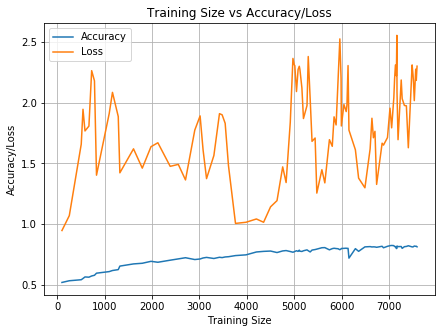

In [7]:
generate_size_graph(1, training_set_size, accuracy_array, loss_array, min(training_set_size), max(training_set_size))

In [ ]:








# cats_copied=5
# dogs_copied=5
# for fil in retrain_set:
#     #print("Retrain File: {}".format(fil))
#     fil_cpy = fil[fil.find('/')+1:]
#     if 'cat' in fil and cats_copied <= to_be_copied:
#         #print(os.path.join(path + "test/cats/"+ fil_cpy))
#         #print(os.path.join(path + "test_copy/"+ fil_cpy))
#         copyfile(os.path.join(path + "test/cats/"+ fil_cpy), os.path.join(path + "test_copy/"+ fil_cpy))
#         cats_copied+=1
#     elif 'dog' in fil and dogs_copied <= to_be_copied:
#         #print(os.path.join(path + "test/dogs/"+ fil_cpy))
#         #print(os.path.join(path + "test_copy/"+ fil_cpy))              
#         copyfile(os.path.join(path + "test/dogs/"+ fil_cpy), os.path.join(path + "test_copy/"+ fil_cpy))
#         dogs_copied+=1
    
#     if cats_copied >= to_be_copied and dogs_copied >= to_be_copied:
#         #print(len(os.listdir(path + "test_copy/")))
#         print(cats_copied, dogs_copied, to_be_copied)
#         break

# print("copy done.")

#move to validation directory
#replenish validation set

#move_to_test(cats_copied+dogs_copied)



        
        
        
        
        
        
        
        
    

    
#     for fil in retrain_set:
#         fil_cpy = fil[fil.find('/')+1:]
#         if 'cat' in fil and cats_copied <= limit:
#             #print(os.path.join(path + "test/cats/"+ fil_cpy))
#             #print(os.path.join(path + "test_copy/"+ fil_cpy))
#             copyfile(os.path.join(path + "test/cats/"+ fil_cpy), os.path.join(path + "test_copy/"+ fil_cpy))
#             cats_copied+=1
#         elif 'dog' in fil and dogs_copied <= limit:
#             #print(os.path.join(path + "test/dogs/"+ fil_cpy))
#             #print(os.path.join(path + "test_copy/"+ fil_cpy))              
#             copyfile(os.path.join(path + "test/dogs/"+ fil_cpy), os.path.join(path + "test_copy/"+ fil_cpy))
#             dogs_copied+=1

#         if cats_copied >= limit and dogs_copied >= limit:
#             #print(len(os.listdir(path + "test_copy/")))
#             print(cats_copied, dogs_copied, limit)
#             break

    
    
    

# def restore_backup(source, destination):
#     %mv $source/cat*.jpg $destination/cats/
#     %mv $source/dog*.jpg $destination/dogs/
    
# def remove_to_backup(source, destination):
#     %mv $source/* $destination/

# remove_to_backup(path + 'train/cats/', path + 'train_bkup/')
# remove_to_backup(path + 'train/dogs/', path + 'train_bkup/')

#restore_backup(path + 'train_bkup', path + 'train')

# nimages = cats_copied + dogs_copied
# def move_to_test(nimages):
#     os.chdir("/home/asaeed9/work/data/2cat/train")
#     g = glob('*.jpg')
#     shuf = np.random.permutation(g)
#     for i in range(nimages): os.rename(shuf[i], '../sample/test/' + shuf[i])
#     os.chdir("../sample/test/")
#     move("cat*.jpg")
#     %mv ../sample/test/cat*.jpg ../sample/cats/
#     %mv ../sample/test/dog*.jpg ../sample/dogs/    




#move_from_test(retrain_set, path, train_size, validation_size)


In [ ]:
model = None
model = get_test_model()
loss_score = []
accuracy_score = []
training_size = [100]

os.chdir(results_path)
files = filter(os.path.isfile, os.listdir(results_path))
files.sort(key=lambda x: os.path.getmtime(x))

for f in files:
    
    print("\nFile being processed: {}".format(f))
    
    train_size = int(f[f.find('_')+1 : f.find('.')])
    epoch = int(f[f.find('e')+1 : ])

    model.load_weights(results_path+'/ft_' + str(train_size) + '.e' + str(epoch))
    
    gen_test = image.ImageDataGenerator()
    test_batches = gen_test.flow_from_directory(path+'test', class_mode=None, target_size=(256,256), shuffle=False, batch_size=1)
    test_data = np.concatenate([test_batches.next() for i in range(test_batches.nb_sample)])
    test_labels = onehot(test_batches.classes)
    score = model.evaluate(test_data, test_labels)
    
    loss_score.append(score[0])
    accuracy_score.append(score[1])
    
    print("\nLoss:{}, Accuracy:{}".format(score[0], score[1]))


In [ ]:
model = None
model = get_test_model()
loss_score = []
accuracy_score = []
training_size = [100]

os.chdir(results_path)
files = filter(os.path.isfile, os.listdir(results_path))
files.sort(key=lambda x: os.path.getmtime(x))

for f in files:
    
    print("\nFile being processed: {}".format(f))
    
    train_size = int(f[f.find('_')+1 : f.find('.')])
    epoch = int(f[f.find('e')+1 : ])

    model.load_weights(results_path+'/ft_' + str(train_size) + '.e' + str(epoch))
    
    gen_test = image.ImageDataGenerator()
    test_batches = gen_test.flow_from_directory(path+'test', class_mode=None, target_size=(256,256), shuffle=False, batch_size=1)
    test_data = np.concatenate([test_batches.next() for i in range(test_batches.nb_sample)])
    test_labels = onehot(test_batches.classes)
    score = model.evaluate(test_data, test_labels)
    
    probs = model.predict(test_data)
    
    loss_score.append(score[0])
    accuracy_score.append(score[1])
    
    print("\nLoss:{}, Accuracy:{}".format(score[0], score[1]))
    print("\nProbabilities:{}".format(probs))


In [ ]:
test_path

In [ ]:
from PIL import Image
Image.open(test_path +  'cats/cat.6013.jpg')


In [ ]:
#probs[:10]
retrain_idx = np.where(np.logical_and(probs >=0.4, probs<=0.6))[0]
retrain_set = [test_batches.filenames[i] for i in retrain_idx]



retrain_set[:10]

In [ ]:
def get_train_model(tr_batches, epoch):
    model = Sequential([
            BatchNormalization(axis=1, input_shape=(3, 256,256)),
            Convolution2D(32,3,3, activation='relu'),
            BatchNormalization(axis=1),
            MaxPooling2D((3,3)),
            Dropout(0.2),
#             Convolution2D(64,3,3, activation='relu'),
#             BatchNormalization(axis=1),
            #MaxPooling2D((3,3)),
            Convolution2D(64,3,3, activation='relu'),
            BatchNormalization(axis=1),
            MaxPooling2D((3,3)),
            Dropout(0.2),
            Convolution2D(32,3,3, activation='relu'),
            BatchNormalization(axis=1),
            MaxPooling2D((3,3)),
            Dropout(0.2),
            Flatten(),
            Dense(1024, activation='relu'),
            BatchNormalization(),
            Dropout(0.2),
            Dense(2, activation='softmax')
        ])

    model.compile(Adam(lr=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])
    #model.fit_generator(tr_batches, tr_batches.nb_sample, nb_epoch=2)
    #model.optimizer.lr = 0.001
    #model.fit_generator(tr_batches, tr_batches.nb_sample, nb_epoch=epoch - 2)
    return model 

In [ ]:
#model = get_train_model(new_data, nepoch)
#model.load_weights(results_path + "/ft_100.e50")
#model.fit_generator(new_data, len(new_data), nb_epoch = 2)